In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [3]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [5]:
suf = '_v1'

data_save_dir = 'data'+suf

In [6]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [7]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [8]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [9]:
len(docs)

1186

In [10]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/B-Drug/B-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [11]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'E-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'E-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'E-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'B-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [12]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [13]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
stacked_embeddings = StackedEmbeddings([
    WordEmbeddings('glove',
                   force_cpu=False,
                #    embedding_length=1024,
                  #  fine_tune=True,
                   ),
    # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
    #                                    subtoken_pooling="first",
    #                                    is_document_embedding=True,
    #                                    fine_tune=True,
    #                                    use_context=True,
    #                                    max_seq_length=1024,
    #                                    ),
    FlairEmbeddings('news-forward',
                    # fine_tune=True
                    ),
    FlairEmbeddings('news-backward',
                    # fine_tune=True
                    ),
])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md

# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        embeddings=stacked_embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        # use_crf=False,
                        # use_rnn=False,
                        # reproject_embeddings=False,
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 01:37:02,589 Filtering empty sentences
2023-04-21 01:37:02,611 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 01:37:02,612 Computing label dictionary. Progress:


948it [00:00, 6599.81it/s]

2023-04-21 01:37:02,762 Dictionary created for label 'ner' with 17 values: O (seen 79057 times), B-ADR (seen 4712 times), I-ADR (seen 4449 times), E-ADR (seen 3506 times), B-Drug (seen 1396 times), B-Finding (seen 309 times), B-Disease (seen 231 times), B-Symptom (seen 222 times), E-Finding (seen 200 times), I-Finding (seen 149 times), E-Disease (seen 119 times), E-Symptom (seen 114 times), E-Drug (seen 111 times), I-Symptom (seen 104 times), I-Drug (seen 50 times), I-Disease (seen 50 times)
False


2023-04-21 01:37:11,209 SequenceTagger predicts: Dictionary with 17 tags: <unk>, O, B-ADR, I-ADR, E-ADR, B-Drug, B-Finding, B-Disease, B-Symptom, E-Finding, I-Finding, E-Disease, E-Symptom, E-Drug, I-Symptom, I-Drug, I-Disease
True
False


In [14]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [15]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 12,
              eval_batch_size = 12,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=1e-1,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 01:37:11,468 tensorboard logging path is runs/tb_logs_v1
2023-04-21 01:37:11,480 ----------------------------------------------------------------------------------------------------
2023-04-21 01:37:11,481 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, bias=True)
  (rnn): LSTM(4196, 256, batch_first=True, bidirectional=True)
  (li

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:38:06,496 Evaluating as a multi-label problem: True


2023-04-21 01:38:08,775 TRAIN : loss 1.620639681816101 - f1-score (weighted avg)  0.065


100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


2023-04-21 01:38:13,449 Evaluating as a multi-label problem: False
2023-04-21 01:38:13,514 DEV : loss 1.6220180988311768 - f1-score (weighted avg)  0.0714
2023-04-21 01:38:13,524 BAD EPOCHS (no improvement): 0
2023-04-21 01:38:13,528 saving best model
2023-04-21 01:38:15,540 ----------------------------------------------------------------------------------------------------
2023-04-21 01:38:17,184 epoch 2 - iter 7/79 - loss 2.07842031 - time (sec): 1.64 - samples/sec: 5203.09 - lr: 0.100000
2023-04-21 01:38:18,703 epoch 2 - iter 14/79 - loss 2.18068577 - time (sec): 3.16 - samples/sec: 5121.74 - lr: 0.100000
2023-04-21 01:38:20,270 epoch 2 - iter 21/79 - loss 2.23710320 - time (sec): 4.73 - samples/sec: 5216.34 - lr: 0.100000
2023-04-21 01:38:22,288 epoch 2 - iter 28/79 - loss 2.39456664 - time (sec): 6.75 - samples/sec: 4949.30 - lr: 0.100000
2023-04-21 01:38:24,392 epoch 2 - iter 35/79 - loss 2.22319636 - time (sec): 8.85 - samples/sec: 4856.75 - lr: 0.100000
2023-04-21 01:38:26,266 

100%|██████████| 79/79 [00:22<00:00,  3.48it/s]

2023-04-21 01:38:58,673 Evaluating as a multi-label problem: True


2023-04-21 01:39:00,939 TRAIN : loss 1.7005283832550049 - f1-score (weighted avg)  0.232


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 01:39:03,817 Evaluating as a multi-label problem: False
2023-04-21 01:39:03,884 DEV : loss 1.6920753717422485 - f1-score (weighted avg)  0.223
2023-04-21 01:39:03,893 BAD EPOCHS (no improvement): 1
2023-04-21 01:39:03,897 ----------------------------------------------------------------------------------------------------


2023-04-21 01:39:05,564 epoch 3 - iter 7/79 - loss 2.92270685 - time (sec): 1.66 - samples/sec: 4730.42 - lr: 0.100000
2023-04-21 01:39:07,158 epoch 3 - iter 14/79 - loss 2.52563672 - time (sec): 3.26 - samples/sec: 5065.70 - lr: 0.100000
2023-04-21 01:39:08,860 epoch 3 - iter 21/79 - loss 2.48414391 - time (sec): 4.96 - samples/sec: 4950.24 - lr: 0.100000
2023-04-21 01:39:10,359 epoch 3 - iter 28/79 - loss 2.30927048 - time (sec): 6.46 - samples/sec: 5045.34 - lr: 0.100000
2023-04-21 01:39:12,255 epoch 3 - iter 35/79 - loss 2.16882463 - time (sec): 8.36 - samples/sec: 4925.97 - lr: 0.100000
2023-04-21 01:39:13,914 epoch 3 - iter 42/79 - loss 2.10839802 - time (sec): 10.02 - samples/sec: 4943.27 - lr: 0.100000
2023-04-21 01:39:15,357 epoch 3 - iter 49/79 - loss 2.09331312 - time (sec): 11.46 - samples/sec: 4990.36 - lr: 0.100000
2023-04-21 01:39:16,760 epoch 3 - iter 56/79 - loss 2.08952814 - time (sec): 12.86 - samples/sec: 5137.66 - lr: 0.100000
2023-04-21 01:39:18,427 epoch 3 - iter

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:39:44,376 Evaluating as a multi-label problem: True


2023-04-21 01:39:46,673 TRAIN : loss 2.2053091526031494 - f1-score (weighted avg)  0.0213


100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

2023-04-21 01:39:50,610 Evaluating as a multi-label problem: False
2023-04-21 01:39:50,674 DEV : loss 2.2307281494140625 - f1-score (weighted avg)  0.0171
2023-04-21 01:39:50,684 Epoch     3: reducing learning rate of group 0 to 5.0000e-02.
2023-04-21 01:39:50,685 BAD EPOCHS (no improvement): 2
2023-04-21 01:39:50,689 ----------------------------------------------------------------------------------------------------


2023-04-21 01:39:52,389 epoch 4 - iter 7/79 - loss 2.12729465 - time (sec): 1.70 - samples/sec: 5125.77 - lr: 0.050000
2023-04-21 01:39:54,618 epoch 4 - iter 14/79 - loss 2.00272651 - time (sec): 3.93 - samples/sec: 4603.68 - lr: 0.050000
2023-04-21 01:39:55,956 epoch 4 - iter 21/79 - loss 2.06955041 - time (sec): 5.27 - samples/sec: 4831.97 - lr: 0.050000
2023-04-21 01:39:57,538 epoch 4 - iter 28/79 - loss 1.95443819 - time (sec): 6.85 - samples/sec: 4911.61 - lr: 0.050000
2023-04-21 01:39:59,315 epoch 4 - iter 35/79 - loss 1.98413529 - time (sec): 8.62 - samples/sec: 4787.99 - lr: 0.050000
2023-04-21 01:40:01,359 epoch 4 - iter 42/79 - loss 1.90862448 - time (sec): 10.67 - samples/sec: 4711.02 - lr: 0.050000
2023-04-21 01:40:03,219 epoch 4 - iter 49/79 - loss 1.90954704 - time (sec): 12.53 - samples/sec: 4715.62 - lr: 0.050000
2023-04-21 01:40:04,738 epoch 4 - iter 56/79 - loss 1.84428117 - time (sec): 14.05 - samples/sec: 4814.35 - lr: 0.050000
2023-04-21 01:40:06,452 epoch 4 - iter

100%|██████████| 79/79 [00:21<00:00,  3.66it/s]

2023-04-21 01:40:32,266 Evaluating as a multi-label problem: True


2023-04-21 01:40:35,890 TRAIN : loss 1.8077532052993774 - f1-score (weighted avg)  0.1056


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 01:40:38,774 Evaluating as a multi-label problem: False
2023-04-21 01:40:38,854 DEV : loss 1.8756130933761597 - f1-score (weighted avg)  0.1
2023-04-21 01:40:38,863 BAD EPOCHS (no improvement): 1
2023-04-21 01:40:38,867 ----------------------------------------------------------------------------------------------------


2023-04-21 01:40:40,662 epoch 5 - iter 7/79 - loss 1.40240675 - time (sec): 1.79 - samples/sec: 4908.87 - lr: 0.050000
2023-04-21 01:40:42,417 epoch 5 - iter 14/79 - loss 1.34595637 - time (sec): 3.55 - samples/sec: 5168.86 - lr: 0.050000
2023-04-21 01:40:44,281 epoch 5 - iter 21/79 - loss 1.38305373 - time (sec): 5.41 - samples/sec: 5020.50 - lr: 0.050000
2023-04-21 01:40:46,339 epoch 5 - iter 28/79 - loss 1.32497640 - time (sec): 7.47 - samples/sec: 4936.09 - lr: 0.050000
2023-04-21 01:40:47,886 epoch 5 - iter 35/79 - loss 1.34061295 - time (sec): 9.02 - samples/sec: 4941.02 - lr: 0.050000
2023-04-21 01:40:49,480 epoch 5 - iter 42/79 - loss 1.32863911 - time (sec): 10.61 - samples/sec: 4970.74 - lr: 0.050000
2023-04-21 01:40:51,836 epoch 5 - iter 49/79 - loss 1.34346558 - time (sec): 12.97 - samples/sec: 4796.82 - lr: 0.050000
2023-04-21 01:40:53,172 epoch 5 - iter 56/79 - loss 1.35208768 - time (sec): 14.30 - samples/sec: 4857.71 - lr: 0.050000
2023-04-21 01:40:54,560 epoch 5 - iter

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:41:19,525 Evaluating as a multi-label problem: True


2023-04-21 01:41:21,724 TRAIN : loss 1.1516971588134766 - f1-score (weighted avg)  0.0945


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 01:41:24,534 Evaluating as a multi-label problem: False
2023-04-21 01:41:24,602 DEV : loss 1.154456377029419 - f1-score (weighted avg)  0.0945
2023-04-21 01:41:24,612 BAD EPOCHS (no improvement): 0
2023-04-21 01:41:24,616 saving best model


2023-04-21 01:41:26,692 ----------------------------------------------------------------------------------------------------
2023-04-21 01:41:28,215 epoch 6 - iter 7/79 - loss 1.36199883 - time (sec): 1.52 - samples/sec: 5096.18 - lr: 0.050000
2023-04-21 01:41:29,927 epoch 6 - iter 14/79 - loss 1.34050180 - time (sec): 3.23 - samples/sec: 5142.03 - lr: 0.050000
2023-04-21 01:41:31,726 epoch 6 - iter 21/79 - loss 1.27342608 - time (sec): 5.03 - samples/sec: 5235.01 - lr: 0.050000
2023-04-21 01:41:33,452 epoch 6 - iter 28/79 - loss 1.26511165 - time (sec): 6.76 - samples/sec: 5208.46 - lr: 0.050000
2023-04-21 01:41:35,328 epoch 6 - iter 35/79 - loss 1.24188278 - time (sec): 8.63 - samples/sec: 5047.17 - lr: 0.050000
2023-04-21 01:41:37,532 epoch 6 - iter 42/79 - loss 1.20265371 - time (sec): 10.84 - samples/sec: 4898.51 - lr: 0.050000
2023-04-21 01:41:39,225 epoch 6 - iter 49/79 - loss 1.17908861 - time (sec): 12.53 - samples/sec: 4880.09 - lr: 0.050000
2023-04-21 01:41:40,849 epoch 6 - 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:42:08,002 Evaluating as a multi-label problem: True


2023-04-21 01:42:11,494 TRAIN : loss 0.8717836141586304 - f1-score (weighted avg)  0.1639


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:42:14,341 Evaluating as a multi-label problem: False
2023-04-21 01:42:14,408 DEV : loss 0.9019215106964111 - f1-score (weighted avg)  0.1771
2023-04-21 01:42:14,418 BAD EPOCHS (no improvement): 0
2023-04-21 01:42:14,423 saving best model


2023-04-21 01:42:16,506 ----------------------------------------------------------------------------------------------------
2023-04-21 01:42:18,059 epoch 7 - iter 7/79 - loss 1.39554461 - time (sec): 1.54 - samples/sec: 5695.56 - lr: 0.050000
2023-04-21 01:42:19,736 epoch 7 - iter 14/79 - loss 1.27425625 - time (sec): 3.22 - samples/sec: 5325.55 - lr: 0.050000
2023-04-21 01:42:21,527 epoch 7 - iter 21/79 - loss 1.17008782 - time (sec): 5.01 - samples/sec: 5090.25 - lr: 0.050000
2023-04-21 01:42:23,552 epoch 7 - iter 28/79 - loss 1.21190576 - time (sec): 7.03 - samples/sec: 5100.97 - lr: 0.050000
2023-04-21 01:42:25,231 epoch 7 - iter 35/79 - loss 1.23173015 - time (sec): 8.71 - samples/sec: 5140.94 - lr: 0.050000
2023-04-21 01:42:26,896 epoch 7 - iter 42/79 - loss 1.21721352 - time (sec): 10.38 - samples/sec: 5078.06 - lr: 0.050000
2023-04-21 01:42:28,409 epoch 7 - iter 49/79 - loss 1.24819598 - time (sec): 11.89 - samples/sec: 5063.14 - lr: 0.050000
2023-04-21 01:42:30,362 epoch 7 - 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:42:57,716 Evaluating as a multi-label problem: True


2023-04-21 01:42:59,955 TRAIN : loss 0.6627253890037537 - f1-score (weighted avg)  0.3197


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 01:43:02,832 Evaluating as a multi-label problem: False
2023-04-21 01:43:02,897 DEV : loss 0.7184054255485535 - f1-score (weighted avg)  0.313
2023-04-21 01:43:02,913 BAD EPOCHS (no improvement): 0
2023-04-21 01:43:02,918 saving best model


2023-04-21 01:43:04,992 ----------------------------------------------------------------------------------------------------
2023-04-21 01:43:06,423 epoch 8 - iter 7/79 - loss 1.29250986 - time (sec): 1.41 - samples/sec: 5227.76 - lr: 0.050000
2023-04-21 01:43:08,409 epoch 8 - iter 14/79 - loss 1.24608116 - time (sec): 3.40 - samples/sec: 4973.91 - lr: 0.050000
2023-04-21 01:43:09,955 epoch 8 - iter 21/79 - loss 1.25182123 - time (sec): 4.95 - samples/sec: 5053.05 - lr: 0.050000
2023-04-21 01:43:11,493 epoch 8 - iter 28/79 - loss 1.21233272 - time (sec): 6.48 - samples/sec: 5084.84 - lr: 0.050000
2023-04-21 01:43:13,539 epoch 8 - iter 35/79 - loss 1.15628299 - time (sec): 8.53 - samples/sec: 4919.98 - lr: 0.050000
2023-04-21 01:43:14,970 epoch 8 - iter 42/79 - loss 1.17207685 - time (sec): 9.96 - samples/sec: 4880.01 - lr: 0.050000
2023-04-21 01:43:16,902 epoch 8 - iter 49/79 - loss 1.15251194 - time (sec): 11.89 - samples/sec: 4800.17 - lr: 0.050000
2023-04-21 01:43:18,662 epoch 8 - i

100%|██████████| 79/79 [00:23<00:00,  3.42it/s]

2023-04-21 01:43:48,056 Evaluating as a multi-label problem: True


2023-04-21 01:43:51,795 TRAIN : loss 1.5408475399017334 - f1-score (weighted avg)  0.0843


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 01:43:54,673 Evaluating as a multi-label problem: False
2023-04-21 01:43:54,746 DEV : loss 1.6126140356063843 - f1-score (weighted avg)  0.0731
2023-04-21 01:43:54,755 BAD EPOCHS (no improvement): 1
2023-04-21 01:43:54,759 ----------------------------------------------------------------------------------------------------


2023-04-21 01:43:56,472 epoch 9 - iter 7/79 - loss 1.45135394 - time (sec): 1.71 - samples/sec: 4515.23 - lr: 0.050000
2023-04-21 01:43:58,106 epoch 9 - iter 14/79 - loss 1.23748734 - time (sec): 3.34 - samples/sec: 4761.79 - lr: 0.050000
2023-04-21 01:44:00,328 epoch 9 - iter 21/79 - loss 1.34387326 - time (sec): 5.57 - samples/sec: 4599.77 - lr: 0.050000
2023-04-21 01:44:02,335 epoch 9 - iter 28/79 - loss 1.39399307 - time (sec): 7.57 - samples/sec: 4529.70 - lr: 0.050000
2023-04-21 01:44:04,015 epoch 9 - iter 35/79 - loss 1.35922565 - time (sec): 9.25 - samples/sec: 4561.84 - lr: 0.050000
2023-04-21 01:44:05,512 epoch 9 - iter 42/79 - loss 1.37583334 - time (sec): 10.75 - samples/sec: 4613.42 - lr: 0.050000
2023-04-21 01:44:07,317 epoch 9 - iter 49/79 - loss 1.36466593 - time (sec): 12.56 - samples/sec: 4645.50 - lr: 0.050000
2023-04-21 01:44:08,922 epoch 9 - iter 56/79 - loss 1.33947834 - time (sec): 14.16 - samples/sec: 4728.78 - lr: 0.050000
2023-04-21 01:44:10,548 epoch 9 - iter

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 01:44:36,218 Evaluating as a multi-label problem: True


2023-04-21 01:44:38,500 TRAIN : loss 0.7558526396751404 - f1-score (weighted avg)  0.2692


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 01:44:41,295 Evaluating as a multi-label problem: False
2023-04-21 01:44:41,359 DEV : loss 0.7895233035087585 - f1-score (weighted avg)  0.2816
2023-04-21 01:44:41,369 Epoch     9: reducing learning rate of group 0 to 2.5000e-02.
2023-04-21 01:44:41,371 BAD EPOCHS (no improvement): 2
2023-04-21 01:44:41,375 ----------------------------------------------------------------------------------------------------


2023-04-21 01:44:43,009 epoch 10 - iter 7/79 - loss 1.02457327 - time (sec): 1.63 - samples/sec: 4994.73 - lr: 0.025000
2023-04-21 01:44:44,687 epoch 10 - iter 14/79 - loss 1.01007959 - time (sec): 3.31 - samples/sec: 4919.21 - lr: 0.025000
2023-04-21 01:44:46,598 epoch 10 - iter 21/79 - loss 1.01769870 - time (sec): 5.22 - samples/sec: 4810.74 - lr: 0.025000
2023-04-21 01:44:48,305 epoch 10 - iter 28/79 - loss 1.02237230 - time (sec): 6.93 - samples/sec: 4802.17 - lr: 0.025000
2023-04-21 01:44:50,039 epoch 10 - iter 35/79 - loss 0.99598757 - time (sec): 8.66 - samples/sec: 4858.21 - lr: 0.025000
2023-04-21 01:44:51,543 epoch 10 - iter 42/79 - loss 0.97670677 - time (sec): 10.17 - samples/sec: 4854.89 - lr: 0.025000
2023-04-21 01:44:53,149 epoch 10 - iter 49/79 - loss 0.94800114 - time (sec): 11.77 - samples/sec: 4888.82 - lr: 0.025000
2023-04-21 01:44:55,502 epoch 10 - iter 56/79 - loss 0.91869466 - time (sec): 14.13 - samples/sec: 4750.37 - lr: 0.025000
2023-04-21 01:44:57,115 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:45:22,857 Evaluating as a multi-label problem: True


2023-04-21 01:45:26,388 TRAIN : loss 0.6128535270690918 - f1-score (weighted avg)  0.2919


100%|██████████| 10/10 [00:02<00:00,  3.72it/s]

2023-04-21 01:45:29,169 Evaluating as a multi-label problem: False
2023-04-21 01:45:29,236 DEV : loss 0.6277104020118713 - f1-score (weighted avg)  0.3098
2023-04-21 01:45:29,245 BAD EPOCHS (no improvement): 0
2023-04-21 01:45:29,249 saving best model


2023-04-21 01:45:31,348 ----------------------------------------------------------------------------------------------------
2023-04-21 01:45:33,563 epoch 11 - iter 7/79 - loss 0.65287012 - time (sec): 2.21 - samples/sec: 3626.53 - lr: 0.025000
2023-04-21 01:45:35,362 epoch 11 - iter 14/79 - loss 0.69423417 - time (sec): 4.01 - samples/sec: 4092.96 - lr: 0.025000
2023-04-21 01:45:36,970 epoch 11 - iter 21/79 - loss 0.71226878 - time (sec): 5.62 - samples/sec: 4463.24 - lr: 0.025000
2023-04-21 01:45:38,639 epoch 11 - iter 28/79 - loss 0.70253258 - time (sec): 7.29 - samples/sec: 4518.93 - lr: 0.025000
2023-04-21 01:45:40,129 epoch 11 - iter 35/79 - loss 0.70208274 - time (sec): 8.78 - samples/sec: 4552.98 - lr: 0.025000
2023-04-21 01:45:41,752 epoch 11 - iter 42/79 - loss 0.69937471 - time (sec): 10.40 - samples/sec: 4620.51 - lr: 0.025000
2023-04-21 01:45:44,072 epoch 11 - iter 49/79 - loss 0.69241640 - time (sec): 12.72 - samples/sec: 4600.42 - lr: 0.025000
2023-04-21 01:45:45,837 epo

100%|██████████| 79/79 [00:21<00:00,  3.74it/s]

2023-04-21 01:46:12,682 Evaluating as a multi-label problem: True


2023-04-21 01:46:14,944 TRAIN : loss 0.8146184086799622 - f1-score (weighted avg)  0.0879


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 01:46:17,795 Evaluating as a multi-label problem: False
2023-04-21 01:46:17,859 DEV : loss 0.8435848951339722 - f1-score (weighted avg)  0.0906
2023-04-21 01:46:17,868 BAD EPOCHS (no improvement): 1
2023-04-21 01:46:17,873 ----------------------------------------------------------------------------------------------------


2023-04-21 01:46:19,322 epoch 12 - iter 7/79 - loss 0.74544615 - time (sec): 1.45 - samples/sec: 5357.14 - lr: 0.025000
2023-04-21 01:46:21,075 epoch 12 - iter 14/79 - loss 0.71992943 - time (sec): 3.20 - samples/sec: 5252.92 - lr: 0.025000
2023-04-21 01:46:22,817 epoch 12 - iter 21/79 - loss 0.72721684 - time (sec): 4.94 - samples/sec: 5105.97 - lr: 0.025000
2023-04-21 01:46:24,555 epoch 12 - iter 28/79 - loss 0.71905591 - time (sec): 6.68 - samples/sec: 5009.71 - lr: 0.025000
2023-04-21 01:46:26,265 epoch 12 - iter 35/79 - loss 0.71132600 - time (sec): 8.39 - samples/sec: 4981.32 - lr: 0.025000
2023-04-21 01:46:28,023 epoch 12 - iter 42/79 - loss 0.69332719 - time (sec): 10.15 - samples/sec: 4897.37 - lr: 0.025000
2023-04-21 01:46:30,396 epoch 12 - iter 49/79 - loss 0.67508285 - time (sec): 12.52 - samples/sec: 4741.90 - lr: 0.025000
2023-04-21 01:46:32,067 epoch 12 - iter 56/79 - loss 0.67705970 - time (sec): 14.19 - samples/sec: 4751.34 - lr: 0.025000
2023-04-21 01:46:33,587 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 01:47:00,192 Evaluating as a multi-label problem: True


2023-04-21 01:47:02,475 TRAIN : loss 0.4492488205432892 - f1-score (weighted avg)  0.3303


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 01:47:05,255 Evaluating as a multi-label problem: False
2023-04-21 01:47:05,324 DEV : loss 0.49424412846565247 - f1-score (weighted avg)  0.3193
2023-04-21 01:47:05,334 BAD EPOCHS (no improvement): 0
2023-04-21 01:47:05,338 saving best model


2023-04-21 01:47:07,431 ----------------------------------------------------------------------------------------------------
2023-04-21 01:47:09,144 epoch 13 - iter 7/79 - loss 0.49939300 - time (sec): 1.71 - samples/sec: 5177.06 - lr: 0.025000
2023-04-21 01:47:10,774 epoch 13 - iter 14/79 - loss 0.63809966 - time (sec): 3.34 - samples/sec: 5176.36 - lr: 0.025000
2023-04-21 01:47:12,724 epoch 13 - iter 21/79 - loss 0.70484954 - time (sec): 5.29 - samples/sec: 4798.37 - lr: 0.025000
2023-04-21 01:47:14,354 epoch 13 - iter 28/79 - loss 0.70807008 - time (sec): 6.92 - samples/sec: 4813.43 - lr: 0.025000
2023-04-21 01:47:16,050 epoch 13 - iter 35/79 - loss 0.72775805 - time (sec): 8.62 - samples/sec: 4729.12 - lr: 0.025000
2023-04-21 01:47:17,656 epoch 13 - iter 42/79 - loss 0.72262142 - time (sec): 10.22 - samples/sec: 4662.58 - lr: 0.025000
2023-04-21 01:47:19,532 epoch 13 - iter 49/79 - loss 0.71798235 - time (sec): 12.10 - samples/sec: 4706.78 - lr: 0.025000
2023-04-21 01:47:21,575 epo

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:47:48,631 Evaluating as a multi-label problem: True


2023-04-21 01:47:52,204 TRAIN : loss 0.5255668759346008 - f1-score (weighted avg)  0.2774


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 01:47:55,020 Evaluating as a multi-label problem: False
2023-04-21 01:47:55,088 DEV : loss 0.5515778064727783 - f1-score (weighted avg)  0.2925
2023-04-21 01:47:55,097 BAD EPOCHS (no improvement): 1
2023-04-21 01:47:55,102 ----------------------------------------------------------------------------------------------------


2023-04-21 01:47:56,581 epoch 14 - iter 7/79 - loss 0.56865980 - time (sec): 1.48 - samples/sec: 5469.14 - lr: 0.025000
2023-04-21 01:47:58,131 epoch 14 - iter 14/79 - loss 0.60008032 - time (sec): 3.03 - samples/sec: 5254.24 - lr: 0.025000
2023-04-21 01:47:59,473 epoch 14 - iter 21/79 - loss 0.60682512 - time (sec): 4.37 - samples/sec: 5321.81 - lr: 0.025000
2023-04-21 01:48:01,284 epoch 14 - iter 28/79 - loss 0.60684850 - time (sec): 6.18 - samples/sec: 5187.46 - lr: 0.025000
2023-04-21 01:48:02,980 epoch 14 - iter 35/79 - loss 0.61899182 - time (sec): 7.88 - samples/sec: 5172.20 - lr: 0.025000
2023-04-21 01:48:04,858 epoch 14 - iter 42/79 - loss 0.63386891 - time (sec): 9.76 - samples/sec: 5125.26 - lr: 0.025000
2023-04-21 01:48:06,534 epoch 14 - iter 49/79 - loss 0.62446266 - time (sec): 11.43 - samples/sec: 5130.63 - lr: 0.025000
2023-04-21 01:48:08,535 epoch 14 - iter 56/79 - loss 0.62048188 - time (sec): 13.43 - samples/sec: 4971.84 - lr: 0.025000
2023-04-21 01:48:10,075 epoch 1

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:48:36,160 Evaluating as a multi-label problem: True


2023-04-21 01:48:38,448 TRAIN : loss 0.45173633098602295 - f1-score (weighted avg)  0.3171


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:48:41,281 Evaluating as a multi-label problem: False
2023-04-21 01:48:41,348 DEV : loss 0.45647749304771423 - f1-score (weighted avg)  0.3354
2023-04-21 01:48:41,357 BAD EPOCHS (no improvement): 0
2023-04-21 01:48:41,362 saving best model


2023-04-21 01:48:43,466 ----------------------------------------------------------------------------------------------------
2023-04-21 01:48:45,298 epoch 15 - iter 7/79 - loss 0.58574968 - time (sec): 1.83 - samples/sec: 4784.74 - lr: 0.025000
2023-04-21 01:48:46,890 epoch 15 - iter 14/79 - loss 0.59432464 - time (sec): 3.42 - samples/sec: 4890.95 - lr: 0.025000
2023-04-21 01:48:48,762 epoch 15 - iter 21/79 - loss 0.59757923 - time (sec): 5.29 - samples/sec: 4809.18 - lr: 0.025000
2023-04-21 01:48:50,545 epoch 15 - iter 28/79 - loss 0.60003284 - time (sec): 7.08 - samples/sec: 4814.88 - lr: 0.025000
2023-04-21 01:48:52,607 epoch 15 - iter 35/79 - loss 0.60942705 - time (sec): 9.14 - samples/sec: 4668.52 - lr: 0.025000
2023-04-21 01:48:54,595 epoch 15 - iter 42/79 - loss 0.61856047 - time (sec): 11.13 - samples/sec: 4631.35 - lr: 0.025000
2023-04-21 01:48:56,438 epoch 15 - iter 49/79 - loss 0.62211663 - time (sec): 12.97 - samples/sec: 4590.90 - lr: 0.025000
2023-04-21 01:48:57,878 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


2023-04-21 01:49:26,430 Evaluating as a multi-label problem: True
2023-04-21 01:49:28,722 TRAIN : loss 0.44462481141090393 - f1-score (weighted avg)  0.3421


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 01:49:31,545 Evaluating as a multi-label problem: False
2023-04-21 01:49:31,618 DEV : loss 0.45877110958099365 - f1-score (weighted avg)  0.3368
2023-04-21 01:49:31,628 BAD EPOCHS (no improvement): 1
2023-04-21 01:49:31,633 ----------------------------------------------------------------------------------------------------


2023-04-21 01:49:33,098 epoch 16 - iter 7/79 - loss 0.59559626 - time (sec): 1.46 - samples/sec: 5283.56 - lr: 0.025000
2023-04-21 01:49:34,514 epoch 16 - iter 14/79 - loss 0.61984577 - time (sec): 2.88 - samples/sec: 5299.71 - lr: 0.025000
2023-04-21 01:49:36,888 epoch 16 - iter 21/79 - loss 0.63568487 - time (sec): 5.25 - samples/sec: 4810.33 - lr: 0.025000
2023-04-21 01:49:38,653 epoch 16 - iter 28/79 - loss 0.63096337 - time (sec): 7.02 - samples/sec: 4706.98 - lr: 0.025000
2023-04-21 01:49:40,437 epoch 16 - iter 35/79 - loss 0.63272144 - time (sec): 8.80 - samples/sec: 4790.73 - lr: 0.025000
2023-04-21 01:49:42,246 epoch 16 - iter 42/79 - loss 0.64439573 - time (sec): 10.61 - samples/sec: 4791.60 - lr: 0.025000
2023-04-21 01:49:43,948 epoch 16 - iter 49/79 - loss 0.64637692 - time (sec): 12.31 - samples/sec: 4796.15 - lr: 0.025000
2023-04-21 01:49:46,116 epoch 16 - iter 56/79 - loss 0.64288005 - time (sec): 14.48 - samples/sec: 4690.06 - lr: 0.025000
2023-04-21 01:49:47,700 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:50:12,675 Evaluating as a multi-label problem: True


2023-04-21 01:50:14,954 TRAIN : loss 0.631736159324646 - f1-score (weighted avg)  0.1055


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 01:50:17,759 Evaluating as a multi-label problem: False
2023-04-21 01:50:17,825 DEV : loss 0.6615258455276489 - f1-score (weighted avg)  0.1243
2023-04-21 01:50:17,834 Epoch    16: reducing learning rate of group 0 to 1.2500e-02.
2023-04-21 01:50:17,836 BAD EPOCHS (no improvement): 2
2023-04-21 01:50:17,850 ----------------------------------------------------------------------------------------------------


2023-04-21 01:50:19,467 epoch 17 - iter 7/79 - loss 0.59108344 - time (sec): 1.61 - samples/sec: 5312.04 - lr: 0.012500
2023-04-21 01:50:21,057 epoch 17 - iter 14/79 - loss 0.59307355 - time (sec): 3.20 - samples/sec: 5301.52 - lr: 0.012500
2023-04-21 01:50:23,367 epoch 17 - iter 21/79 - loss 0.59593814 - time (sec): 5.52 - samples/sec: 4838.79 - lr: 0.012500
2023-04-21 01:50:25,154 epoch 17 - iter 28/79 - loss 0.59190846 - time (sec): 7.30 - samples/sec: 4909.04 - lr: 0.012500
2023-04-21 01:50:26,711 epoch 17 - iter 35/79 - loss 0.59269831 - time (sec): 8.86 - samples/sec: 4908.27 - lr: 0.012500
2023-04-21 01:50:28,432 epoch 17 - iter 42/79 - loss 0.57553270 - time (sec): 10.58 - samples/sec: 4853.39 - lr: 0.012500
2023-04-21 01:50:30,069 epoch 17 - iter 49/79 - loss 0.56587102 - time (sec): 12.22 - samples/sec: 4834.57 - lr: 0.012500
2023-04-21 01:50:31,645 epoch 17 - iter 56/79 - loss 0.55866121 - time (sec): 13.79 - samples/sec: 4823.62 - lr: 0.012500
2023-04-21 01:50:33,361 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 01:51:00,081 Evaluating as a multi-label problem: True


2023-04-21 01:51:02,359 TRAIN : loss 0.38410213589668274 - f1-score (weighted avg)  0.3283


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:51:05,186 Evaluating as a multi-label problem: False
2023-04-21 01:51:05,255 DEV : loss 0.4051736891269684 - f1-score (weighted avg)  0.3394
2023-04-21 01:51:05,265 BAD EPOCHS (no improvement): 0
2023-04-21 01:51:05,269 saving best model


2023-04-21 01:51:07,380 ----------------------------------------------------------------------------------------------------
2023-04-21 01:51:08,837 epoch 18 - iter 7/79 - loss 0.52628897 - time (sec): 1.45 - samples/sec: 5176.23 - lr: 0.012500
2023-04-21 01:51:11,021 epoch 18 - iter 14/79 - loss 0.51689308 - time (sec): 3.64 - samples/sec: 4282.56 - lr: 0.012500
2023-04-21 01:51:12,564 epoch 18 - iter 21/79 - loss 0.52433285 - time (sec): 5.18 - samples/sec: 4646.08 - lr: 0.012500
2023-04-21 01:51:14,052 epoch 18 - iter 28/79 - loss 0.53246114 - time (sec): 6.67 - samples/sec: 4770.31 - lr: 0.012500
2023-04-21 01:51:15,821 epoch 18 - iter 35/79 - loss 0.54323964 - time (sec): 8.44 - samples/sec: 4794.00 - lr: 0.012500
2023-04-21 01:51:17,791 epoch 18 - iter 42/79 - loss 0.54825911 - time (sec): 10.41 - samples/sec: 4754.62 - lr: 0.012500
2023-04-21 01:51:20,213 epoch 18 - iter 49/79 - loss 0.53247927 - time (sec): 12.83 - samples/sec: 4621.91 - lr: 0.012500
2023-04-21 01:51:21,710 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:51:48,545 Evaluating as a multi-label problem: True


2023-04-21 01:51:52,081 TRAIN : loss 0.3809095323085785 - f1-score (weighted avg)  0.2977


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:51:54,889 Evaluating as a multi-label problem: False
2023-04-21 01:51:54,960 DEV : loss 0.3844245374202728 - f1-score (weighted avg)  0.3109
2023-04-21 01:51:54,969 BAD EPOCHS (no improvement): 0
2023-04-21 01:51:54,973 saving best model


2023-04-21 01:51:57,069 ----------------------------------------------------------------------------------------------------
2023-04-21 01:51:58,826 epoch 19 - iter 7/79 - loss 0.44335154 - time (sec): 1.75 - samples/sec: 4974.02 - lr: 0.012500
2023-04-21 01:52:00,287 epoch 19 - iter 14/79 - loss 0.45667725 - time (sec): 3.22 - samples/sec: 5100.35 - lr: 0.012500
2023-04-21 01:52:02,152 epoch 19 - iter 21/79 - loss 0.46541431 - time (sec): 5.08 - samples/sec: 4668.43 - lr: 0.012500
2023-04-21 01:52:03,797 epoch 19 - iter 28/79 - loss 0.46273756 - time (sec): 6.73 - samples/sec: 4779.02 - lr: 0.012500
2023-04-21 01:52:05,667 epoch 19 - iter 35/79 - loss 0.47251472 - time (sec): 8.60 - samples/sec: 4686.32 - lr: 0.012500
2023-04-21 01:52:07,521 epoch 19 - iter 42/79 - loss 0.46895600 - time (sec): 10.45 - samples/sec: 4660.97 - lr: 0.012500
2023-04-21 01:52:09,057 epoch 19 - iter 49/79 - loss 0.47510507 - time (sec): 11.99 - samples/sec: 4690.76 - lr: 0.012500
2023-04-21 01:52:11,608 epo

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 01:52:38,796 Evaluating as a multi-label problem: True


2023-04-21 01:52:41,090 TRAIN : loss 0.32065215706825256 - f1-score (weighted avg)  0.3163


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 01:52:43,951 Evaluating as a multi-label problem: False
2023-04-21 01:52:44,020 DEV : loss 0.33562713861465454 - f1-score (weighted avg)  0.3071
2023-04-21 01:52:44,030 BAD EPOCHS (no improvement): 0
2023-04-21 01:52:44,034 saving best model


2023-04-21 01:52:46,147 ----------------------------------------------------------------------------------------------------
2023-04-21 01:52:47,749 epoch 20 - iter 7/79 - loss 0.47917691 - time (sec): 1.60 - samples/sec: 4844.43 - lr: 0.012500
2023-04-21 01:52:49,582 epoch 20 - iter 14/79 - loss 0.49961809 - time (sec): 3.43 - samples/sec: 4870.86 - lr: 0.012500
2023-04-21 01:52:51,321 epoch 20 - iter 21/79 - loss 0.48384501 - time (sec): 5.17 - samples/sec: 5013.72 - lr: 0.012500
2023-04-21 01:52:53,082 epoch 20 - iter 28/79 - loss 0.48517420 - time (sec): 6.93 - samples/sec: 5002.89 - lr: 0.012500
2023-04-21 01:52:54,464 epoch 20 - iter 35/79 - loss 0.48132225 - time (sec): 8.32 - samples/sec: 5071.55 - lr: 0.012500
2023-04-21 01:52:56,332 epoch 20 - iter 42/79 - loss 0.47853189 - time (sec): 10.18 - samples/sec: 5036.68 - lr: 0.012500
2023-04-21 01:52:58,116 epoch 20 - iter 49/79 - loss 0.47844056 - time (sec): 11.97 - samples/sec: 4998.51 - lr: 0.012500
2023-04-21 01:52:59,498 epo

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 01:53:28,140 Evaluating as a multi-label problem: True


2023-04-21 01:53:30,467 TRAIN : loss 0.3540274202823639 - f1-score (weighted avg)  0.3176


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:53:33,273 Evaluating as a multi-label problem: False
2023-04-21 01:53:33,342 DEV : loss 0.3610313832759857 - f1-score (weighted avg)  0.3231
2023-04-21 01:53:33,352 BAD EPOCHS (no improvement): 1
2023-04-21 01:53:33,356 ----------------------------------------------------------------------------------------------------


2023-04-21 01:53:35,175 epoch 21 - iter 7/79 - loss 0.43701777 - time (sec): 1.82 - samples/sec: 4574.66 - lr: 0.012500
2023-04-21 01:53:37,000 epoch 21 - iter 14/79 - loss 0.46208891 - time (sec): 3.64 - samples/sec: 4674.92 - lr: 0.012500
2023-04-21 01:53:38,705 epoch 21 - iter 21/79 - loss 0.44794048 - time (sec): 5.35 - samples/sec: 4749.44 - lr: 0.012500
2023-04-21 01:53:40,295 epoch 21 - iter 28/79 - loss 0.44918776 - time (sec): 6.94 - samples/sec: 4933.27 - lr: 0.012500
2023-04-21 01:53:41,905 epoch 21 - iter 35/79 - loss 0.44921540 - time (sec): 8.55 - samples/sec: 4973.22 - lr: 0.012500
2023-04-21 01:53:43,482 epoch 21 - iter 42/79 - loss 0.45266293 - time (sec): 10.12 - samples/sec: 4956.10 - lr: 0.012500
2023-04-21 01:53:45,127 epoch 21 - iter 49/79 - loss 0.46310382 - time (sec): 11.77 - samples/sec: 4991.74 - lr: 0.012500
2023-04-21 01:53:46,902 epoch 21 - iter 56/79 - loss 0.45650510 - time (sec): 13.54 - samples/sec: 4983.22 - lr: 0.012500
2023-04-21 01:53:49,217 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:54:14,466 Evaluating as a multi-label problem: True


2023-04-21 01:54:18,038 TRAIN : loss 0.3453005254268646 - f1-score (weighted avg)  0.293


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 01:54:20,829 Evaluating as a multi-label problem: False
2023-04-21 01:54:20,896 DEV : loss 0.3505595624446869 - f1-score (weighted avg)  0.2961
2023-04-21 01:54:20,907 Epoch    21: reducing learning rate of group 0 to 6.2500e-03.
2023-04-21 01:54:20,909 BAD EPOCHS (no improvement): 2
2023-04-21 01:54:20,912 ----------------------------------------------------------------------------------------------------


2023-04-21 01:54:22,374 epoch 22 - iter 7/79 - loss 0.44933411 - time (sec): 1.46 - samples/sec: 5497.95 - lr: 0.006250
2023-04-21 01:54:24,079 epoch 22 - iter 14/79 - loss 0.45198079 - time (sec): 3.16 - samples/sec: 5139.30 - lr: 0.006250
2023-04-21 01:54:25,727 epoch 22 - iter 21/79 - loss 0.46281450 - time (sec): 4.81 - samples/sec: 5032.07 - lr: 0.006250
2023-04-21 01:54:27,148 epoch 22 - iter 28/79 - loss 0.46440001 - time (sec): 6.23 - samples/sec: 5139.70 - lr: 0.006250
2023-04-21 01:54:29,051 epoch 22 - iter 35/79 - loss 0.45029245 - time (sec): 8.14 - samples/sec: 4931.98 - lr: 0.006250
2023-04-21 01:54:30,560 epoch 22 - iter 42/79 - loss 0.44025362 - time (sec): 9.65 - samples/sec: 5026.35 - lr: 0.006250
2023-04-21 01:54:32,730 epoch 22 - iter 49/79 - loss 0.42987162 - time (sec): 11.82 - samples/sec: 5021.91 - lr: 0.006250
2023-04-21 01:54:34,071 epoch 22 - iter 56/79 - loss 0.43803604 - time (sec): 13.16 - samples/sec: 5041.62 - lr: 0.006250
2023-04-21 01:54:36,222 epoch 2

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:55:01,573 Evaluating as a multi-label problem: True


2023-04-21 01:55:03,867 TRAIN : loss 0.31101834774017334 - f1-score (weighted avg)  0.3343


100%|██████████| 10/10 [00:02<00:00,  3.58it/s]

2023-04-21 01:55:06,739 Evaluating as a multi-label problem: False
2023-04-21 01:55:06,808 DEV : loss 0.32398301362991333 - f1-score (weighted avg)  0.3158
2023-04-21 01:55:06,820 BAD EPOCHS (no improvement): 0
2023-04-21 01:55:06,824 saving best model


2023-04-21 01:55:08,896 ----------------------------------------------------------------------------------------------------
2023-04-21 01:55:10,545 epoch 23 - iter 7/79 - loss 0.40767466 - time (sec): 1.65 - samples/sec: 4815.04 - lr: 0.006250
2023-04-21 01:55:12,199 epoch 23 - iter 14/79 - loss 0.41630058 - time (sec): 3.30 - samples/sec: 5124.36 - lr: 0.006250
2023-04-21 01:55:14,008 epoch 23 - iter 21/79 - loss 0.40522323 - time (sec): 5.11 - samples/sec: 4810.47 - lr: 0.006250
2023-04-21 01:55:16,024 epoch 23 - iter 28/79 - loss 0.40691391 - time (sec): 7.13 - samples/sec: 4536.25 - lr: 0.006250
2023-04-21 01:55:18,417 epoch 23 - iter 35/79 - loss 0.39510581 - time (sec): 9.52 - samples/sec: 4458.49 - lr: 0.006250
2023-04-21 01:55:19,960 epoch 23 - iter 42/79 - loss 0.39058298 - time (sec): 11.06 - samples/sec: 4592.89 - lr: 0.006250
2023-04-21 01:55:21,750 epoch 23 - iter 49/79 - loss 0.39471505 - time (sec): 12.85 - samples/sec: 4645.61 - lr: 0.006250
2023-04-21 01:55:23,354 epo

100%|██████████| 79/79 [00:22<00:00,  3.53it/s]

2023-04-21 01:55:51,521 Evaluating as a multi-label problem: True


2023-04-21 01:55:53,794 TRAIN : loss 0.3111548125743866 - f1-score (weighted avg)  0.3184


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 01:55:56,611 Evaluating as a multi-label problem: False
2023-04-21 01:55:56,678 DEV : loss 0.3191471993923187 - f1-score (weighted avg)  0.3253
2023-04-21 01:55:56,688 BAD EPOCHS (no improvement): 0
2023-04-21 01:55:56,692 saving best model


2023-04-21 01:55:58,793 ----------------------------------------------------------------------------------------------------
2023-04-21 01:56:00,334 epoch 24 - iter 7/79 - loss 0.37479217 - time (sec): 1.54 - samples/sec: 4958.83 - lr: 0.006250
2023-04-21 01:56:01,847 epoch 24 - iter 14/79 - loss 0.37781780 - time (sec): 3.05 - samples/sec: 5064.57 - lr: 0.006250
2023-04-21 01:56:03,366 epoch 24 - iter 21/79 - loss 0.37838934 - time (sec): 4.57 - samples/sec: 5234.52 - lr: 0.006250
2023-04-21 01:56:05,262 epoch 24 - iter 28/79 - loss 0.38408651 - time (sec): 6.47 - samples/sec: 5152.49 - lr: 0.006250
2023-04-21 01:56:06,778 epoch 24 - iter 35/79 - loss 0.39168671 - time (sec): 7.98 - samples/sec: 5143.26 - lr: 0.006250
2023-04-21 01:56:09,127 epoch 24 - iter 42/79 - loss 0.39011213 - time (sec): 10.33 - samples/sec: 4945.57 - lr: 0.006250
2023-04-21 01:56:11,063 epoch 24 - iter 49/79 - loss 0.39464349 - time (sec): 12.27 - samples/sec: 4913.34 - lr: 0.006250
2023-04-21 01:56:12,675 epo

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 01:56:39,497 Evaluating as a multi-label problem: True


2023-04-21 01:56:43,067 TRAIN : loss 0.29382815957069397 - f1-score (weighted avg)  0.3261


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 01:56:45,905 Evaluating as a multi-label problem: False
2023-04-21 01:56:45,973 DEV : loss 0.3001489043235779 - f1-score (weighted avg)  0.3316
2023-04-21 01:56:45,982 BAD EPOCHS (no improvement): 0
2023-04-21 01:56:45,987 saving best model


2023-04-21 01:56:48,074 ----------------------------------------------------------------------------------------------------
2023-04-21 01:56:49,461 epoch 25 - iter 7/79 - loss 0.34111776 - time (sec): 1.39 - samples/sec: 4920.49 - lr: 0.006250
2023-04-21 01:56:51,225 epoch 25 - iter 14/79 - loss 0.37429765 - time (sec): 3.15 - samples/sec: 4911.00 - lr: 0.006250
2023-04-21 01:56:52,786 epoch 25 - iter 21/79 - loss 0.37994439 - time (sec): 4.71 - samples/sec: 5009.71 - lr: 0.006250
2023-04-21 01:56:54,223 epoch 25 - iter 28/79 - loss 0.37543556 - time (sec): 6.15 - samples/sec: 5029.04 - lr: 0.006250
2023-04-21 01:56:56,426 epoch 25 - iter 35/79 - loss 0.37683194 - time (sec): 8.35 - samples/sec: 4826.64 - lr: 0.006250
2023-04-21 01:56:58,381 epoch 25 - iter 42/79 - loss 0.37972380 - time (sec): 10.31 - samples/sec: 4757.51 - lr: 0.006250
2023-04-21 01:57:00,056 epoch 25 - iter 49/79 - loss 0.38286427 - time (sec): 11.98 - samples/sec: 4817.71 - lr: 0.006250
2023-04-21 01:57:01,982 epo

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 01:57:29,532 Evaluating as a multi-label problem: True


2023-04-21 01:57:31,823 TRAIN : loss 0.3006163537502289 - f1-score (weighted avg)  0.3238


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 01:57:34,628 Evaluating as a multi-label problem: False
2023-04-21 01:57:34,696 DEV : loss 0.30892184376716614 - f1-score (weighted avg)  0.3197
2023-04-21 01:57:34,706 BAD EPOCHS (no improvement): 1
2023-04-21 01:57:34,710 ----------------------------------------------------------------------------------------------------


2023-04-21 01:57:36,316 epoch 26 - iter 7/79 - loss 0.34419619 - time (sec): 1.60 - samples/sec: 5430.12 - lr: 0.006250
2023-04-21 01:57:37,791 epoch 26 - iter 14/79 - loss 0.38114838 - time (sec): 3.08 - samples/sec: 5289.42 - lr: 0.006250
2023-04-21 01:57:40,066 epoch 26 - iter 21/79 - loss 0.37916820 - time (sec): 5.35 - samples/sec: 4886.47 - lr: 0.006250
2023-04-21 01:57:42,068 epoch 26 - iter 28/79 - loss 0.38102810 - time (sec): 7.36 - samples/sec: 4785.18 - lr: 0.006250
2023-04-21 01:57:43,851 epoch 26 - iter 35/79 - loss 0.37488598 - time (sec): 9.14 - samples/sec: 4804.01 - lr: 0.006250
2023-04-21 01:57:45,841 epoch 26 - iter 42/79 - loss 0.38095423 - time (sec): 11.13 - samples/sec: 4727.02 - lr: 0.006250
2023-04-21 01:57:47,357 epoch 26 - iter 49/79 - loss 0.38352358 - time (sec): 12.65 - samples/sec: 4733.98 - lr: 0.006250
2023-04-21 01:57:48,881 epoch 26 - iter 56/79 - loss 0.38192774 - time (sec): 14.17 - samples/sec: 4792.79 - lr: 0.006250
2023-04-21 01:57:50,533 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


2023-04-21 01:58:16,925 Evaluating as a multi-label problem: True
2023-04-21 01:58:19,218 TRAIN : loss 0.31123775243759155 - f1-score (weighted avg)  0.2846


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:58:22,054 Evaluating as a multi-label problem: False
2023-04-21 01:58:22,124 DEV : loss 0.3202229142189026 - f1-score (weighted avg)  0.2774
2023-04-21 01:58:22,134 Epoch    26: reducing learning rate of group 0 to 3.1250e-03.
2023-04-21 01:58:22,136 BAD EPOCHS (no improvement): 2
2023-04-21 01:58:22,140 ----------------------------------------------------------------------------------------------------


2023-04-21 01:58:23,801 epoch 27 - iter 7/79 - loss 0.39589420 - time (sec): 1.66 - samples/sec: 5107.35 - lr: 0.003125
2023-04-21 01:58:25,342 epoch 27 - iter 14/79 - loss 0.37329475 - time (sec): 3.20 - samples/sec: 5023.43 - lr: 0.003125
2023-04-21 01:58:27,262 epoch 27 - iter 21/79 - loss 0.36290826 - time (sec): 5.12 - samples/sec: 4802.68 - lr: 0.003125
2023-04-21 01:58:28,953 epoch 27 - iter 28/79 - loss 0.36327456 - time (sec): 6.81 - samples/sec: 4887.48 - lr: 0.003125
2023-04-21 01:58:30,488 epoch 27 - iter 35/79 - loss 0.36773621 - time (sec): 8.35 - samples/sec: 4920.42 - lr: 0.003125
2023-04-21 01:58:32,363 epoch 27 - iter 42/79 - loss 0.37135928 - time (sec): 10.22 - samples/sec: 4879.36 - lr: 0.003125
2023-04-21 01:58:34,279 epoch 27 - iter 49/79 - loss 0.36771604 - time (sec): 12.14 - samples/sec: 4924.53 - lr: 0.003125
2023-04-21 01:58:35,816 epoch 27 - iter 56/79 - loss 0.36801515 - time (sec): 13.67 - samples/sec: 4957.96 - lr: 0.003125
2023-04-21 01:58:37,371 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:59:03,355 Evaluating as a multi-label problem: True


2023-04-21 01:59:07,000 TRAIN : loss 0.28926950693130493 - f1-score (weighted avg)  0.3354


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 01:59:09,831 Evaluating as a multi-label problem: False
2023-04-21 01:59:09,898 DEV : loss 0.29435789585113525 - f1-score (weighted avg)  0.334
2023-04-21 01:59:09,907 BAD EPOCHS (no improvement): 0
2023-04-21 01:59:09,912 saving best model


2023-04-21 01:59:11,984 ----------------------------------------------------------------------------------------------------
2023-04-21 01:59:14,224 epoch 28 - iter 7/79 - loss 0.37715729 - time (sec): 2.24 - samples/sec: 3984.59 - lr: 0.003125
2023-04-21 01:59:15,797 epoch 28 - iter 14/79 - loss 0.38518844 - time (sec): 3.81 - samples/sec: 4547.91 - lr: 0.003125
2023-04-21 01:59:17,799 epoch 28 - iter 21/79 - loss 0.37645552 - time (sec): 5.81 - samples/sec: 4561.32 - lr: 0.003125
2023-04-21 01:59:19,355 epoch 28 - iter 28/79 - loss 0.37297700 - time (sec): 7.37 - samples/sec: 4695.75 - lr: 0.003125
2023-04-21 01:59:21,286 epoch 28 - iter 35/79 - loss 0.36561258 - time (sec): 9.30 - samples/sec: 4667.14 - lr: 0.003125
2023-04-21 01:59:22,892 epoch 28 - iter 42/79 - loss 0.37182146 - time (sec): 10.91 - samples/sec: 4670.71 - lr: 0.003125
2023-04-21 01:59:24,649 epoch 28 - iter 49/79 - loss 0.36839314 - time (sec): 12.66 - samples/sec: 4656.39 - lr: 0.003125
2023-04-21 01:59:26,619 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 01:59:53,633 Evaluating as a multi-label problem: True


2023-04-21 01:59:55,928 TRAIN : loss 0.28587400913238525 - f1-score (weighted avg)  0.3332


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 01:59:58,743 Evaluating as a multi-label problem: False
2023-04-21 01:59:58,811 DEV : loss 0.2950611710548401 - f1-score (weighted avg)  0.3238
2023-04-21 01:59:58,821 BAD EPOCHS (no improvement): 1
2023-04-21 01:59:58,825 ----------------------------------------------------------------------------------------------------


2023-04-21 02:00:00,692 epoch 29 - iter 7/79 - loss 0.32162528 - time (sec): 1.87 - samples/sec: 4239.71 - lr: 0.003125
2023-04-21 02:00:02,383 epoch 29 - iter 14/79 - loss 0.36214639 - time (sec): 3.56 - samples/sec: 4668.13 - lr: 0.003125
2023-04-21 02:00:04,077 epoch 29 - iter 21/79 - loss 0.36692807 - time (sec): 5.25 - samples/sec: 4631.82 - lr: 0.003125
2023-04-21 02:00:05,611 epoch 29 - iter 28/79 - loss 0.36747046 - time (sec): 6.78 - samples/sec: 4940.89 - lr: 0.003125
2023-04-21 02:00:07,302 epoch 29 - iter 35/79 - loss 0.36563254 - time (sec): 8.47 - samples/sec: 5046.71 - lr: 0.003125
2023-04-21 02:00:09,408 epoch 29 - iter 42/79 - loss 0.36238841 - time (sec): 10.58 - samples/sec: 4832.56 - lr: 0.003125
2023-04-21 02:00:11,269 epoch 29 - iter 49/79 - loss 0.36377981 - time (sec): 12.44 - samples/sec: 4843.42 - lr: 0.003125
2023-04-21 02:00:13,181 epoch 29 - iter 56/79 - loss 0.35538567 - time (sec): 14.35 - samples/sec: 4789.19 - lr: 0.003125
2023-04-21 02:00:14,793 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


2023-04-21 02:00:41,187 Evaluating as a multi-label problem: True
2023-04-21 02:00:43,483 TRAIN : loss 0.29707828164100647 - f1-score (weighted avg)  0.3378


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 02:00:46,272 Evaluating as a multi-label problem: False
2023-04-21 02:00:46,339 DEV : loss 0.30746668577194214 - f1-score (weighted avg)  0.3328
2023-04-21 02:00:46,349 Epoch    29: reducing learning rate of group 0 to 1.5625e-03.
2023-04-21 02:00:46,351 BAD EPOCHS (no improvement): 2
2023-04-21 02:00:46,355 ----------------------------------------------------------------------------------------------------


2023-04-21 02:00:48,163 epoch 30 - iter 7/79 - loss 0.35559110 - time (sec): 1.81 - samples/sec: 4823.13 - lr: 0.001563
2023-04-21 02:00:50,006 epoch 30 - iter 14/79 - loss 0.35103926 - time (sec): 3.65 - samples/sec: 4691.08 - lr: 0.001563
2023-04-21 02:00:51,547 epoch 30 - iter 21/79 - loss 0.34254438 - time (sec): 5.19 - samples/sec: 4836.17 - lr: 0.001563
2023-04-21 02:00:53,063 epoch 30 - iter 28/79 - loss 0.34702324 - time (sec): 6.71 - samples/sec: 4937.12 - lr: 0.001563
2023-04-21 02:00:54,845 epoch 30 - iter 35/79 - loss 0.34704986 - time (sec): 8.49 - samples/sec: 4868.88 - lr: 0.001563
2023-04-21 02:00:56,846 epoch 30 - iter 42/79 - loss 0.34313394 - time (sec): 10.49 - samples/sec: 4855.79 - lr: 0.001563
2023-04-21 02:00:58,865 epoch 30 - iter 49/79 - loss 0.34165169 - time (sec): 12.51 - samples/sec: 4786.43 - lr: 0.001563
2023-04-21 02:01:00,698 epoch 30 - iter 56/79 - loss 0.34947639 - time (sec): 14.34 - samples/sec: 4754.46 - lr: 0.001563
2023-04-21 02:01:02,244 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.69it/s]

2023-04-21 02:01:27,542 Evaluating as a multi-label problem: True


2023-04-21 02:01:29,837 TRAIN : loss 0.28387215733528137 - f1-score (weighted avg)  0.3372


100%|██████████| 10/10 [00:02<00:00,  3.63it/s]

2023-04-21 02:01:32,685 Evaluating as a multi-label problem: False
2023-04-21 02:01:32,753 DEV : loss 0.29396435618400574 - f1-score (weighted avg)  0.3253
2023-04-21 02:01:32,764 BAD EPOCHS (no improvement): 0
2023-04-21 02:01:32,768 saving best model


2023-04-21 02:01:34,866 ----------------------------------------------------------------------------------------------------
2023-04-21 02:01:36,414 epoch 31 - iter 7/79 - loss 0.35829673 - time (sec): 1.55 - samples/sec: 5386.53 - lr: 0.001563
2023-04-21 02:01:38,015 epoch 31 - iter 14/79 - loss 0.33469096 - time (sec): 3.15 - samples/sec: 5203.76 - lr: 0.001563
2023-04-21 02:01:39,911 epoch 31 - iter 21/79 - loss 0.34186734 - time (sec): 5.04 - samples/sec: 4957.90 - lr: 0.001563
2023-04-21 02:01:41,638 epoch 31 - iter 28/79 - loss 0.35200924 - time (sec): 6.77 - samples/sec: 4934.55 - lr: 0.001563
2023-04-21 02:01:43,937 epoch 31 - iter 35/79 - loss 0.35545686 - time (sec): 9.07 - samples/sec: 4654.85 - lr: 0.001563
2023-04-21 02:01:45,705 epoch 31 - iter 42/79 - loss 0.35751819 - time (sec): 10.84 - samples/sec: 4633.29 - lr: 0.001563
2023-04-21 02:01:47,715 epoch 31 - iter 49/79 - loss 0.35573020 - time (sec): 12.85 - samples/sec: 4566.31 - lr: 0.001563
2023-04-21 02:01:49,251 epo

100%|██████████| 79/79 [00:22<00:00,  3.53it/s]

2023-04-21 02:02:17,515 Evaluating as a multi-label problem: True


2023-04-21 02:02:19,818 TRAIN : loss 0.28765761852264404 - f1-score (weighted avg)  0.3067


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 02:02:22,603 Evaluating as a multi-label problem: False
2023-04-21 02:02:22,670 DEV : loss 0.2948721945285797 - f1-score (weighted avg)  0.3083
2023-04-21 02:02:22,680 BAD EPOCHS (no improvement): 1
2023-04-21 02:02:22,684 ----------------------------------------------------------------------------------------------------


2023-04-21 02:02:24,353 epoch 32 - iter 7/79 - loss 0.38533648 - time (sec): 1.67 - samples/sec: 5025.42 - lr: 0.001563
2023-04-21 02:02:25,883 epoch 32 - iter 14/79 - loss 0.35707374 - time (sec): 3.20 - samples/sec: 5136.54 - lr: 0.001563
2023-04-21 02:02:28,132 epoch 32 - iter 21/79 - loss 0.35548083 - time (sec): 5.45 - samples/sec: 4630.58 - lr: 0.001563
2023-04-21 02:02:29,917 epoch 32 - iter 28/79 - loss 0.35937109 - time (sec): 7.23 - samples/sec: 4696.79 - lr: 0.001563
2023-04-21 02:02:31,609 epoch 32 - iter 35/79 - loss 0.35089743 - time (sec): 8.92 - samples/sec: 4732.00 - lr: 0.001563
2023-04-21 02:02:33,208 epoch 32 - iter 42/79 - loss 0.34976912 - time (sec): 10.52 - samples/sec: 4774.34 - lr: 0.001563
2023-04-21 02:02:35,299 epoch 32 - iter 49/79 - loss 0.34500137 - time (sec): 12.61 - samples/sec: 4707.61 - lr: 0.001563
2023-04-21 02:02:36,671 epoch 32 - iter 56/79 - loss 0.34369602 - time (sec): 13.99 - samples/sec: 4835.74 - lr: 0.001563
2023-04-21 02:02:38,320 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 02:03:03,488 Evaluating as a multi-label problem: True


2023-04-21 02:03:07,013 TRAIN : loss 0.27820318937301636 - f1-score (weighted avg)  0.3257


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:03:09,820 Evaluating as a multi-label problem: False
2023-04-21 02:03:09,888 DEV : loss 0.2860194444656372 - f1-score (weighted avg)  0.3281
2023-04-21 02:03:09,899 BAD EPOCHS (no improvement): 0
2023-04-21 02:03:09,903 saving best model


2023-04-21 02:03:11,992 ----------------------------------------------------------------------------------------------------
2023-04-21 02:03:13,936 epoch 33 - iter 7/79 - loss 0.27634413 - time (sec): 1.92 - samples/sec: 4657.59 - lr: 0.001563
2023-04-21 02:03:15,610 epoch 33 - iter 14/79 - loss 0.32335964 - time (sec): 3.59 - samples/sec: 4929.71 - lr: 0.001563
2023-04-21 02:03:17,474 epoch 33 - iter 21/79 - loss 0.33187738 - time (sec): 5.46 - samples/sec: 4805.63 - lr: 0.001563
2023-04-21 02:03:19,141 epoch 33 - iter 28/79 - loss 0.33999516 - time (sec): 7.12 - samples/sec: 4823.95 - lr: 0.001563
2023-04-21 02:03:20,468 epoch 33 - iter 35/79 - loss 0.34515393 - time (sec): 8.45 - samples/sec: 4939.71 - lr: 0.001563
2023-04-21 02:03:22,141 epoch 33 - iter 42/79 - loss 0.34464805 - time (sec): 10.12 - samples/sec: 4980.75 - lr: 0.001563
2023-04-21 02:03:23,883 epoch 33 - iter 49/79 - loss 0.34547401 - time (sec): 11.87 - samples/sec: 4977.98 - lr: 0.001563
2023-04-21 02:03:25,546 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:03:53,194 Evaluating as a multi-label problem: True


2023-04-21 02:03:55,489 TRAIN : loss 0.2817997634410858 - f1-score (weighted avg)  0.3224


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:03:58,322 Evaluating as a multi-label problem: False
2023-04-21 02:03:58,391 DEV : loss 0.2896963655948639 - f1-score (weighted avg)  0.3222
2023-04-21 02:03:58,401 BAD EPOCHS (no improvement): 1
2023-04-21 02:03:58,406 ----------------------------------------------------------------------------------------------------


2023-04-21 02:03:59,968 epoch 34 - iter 7/79 - loss 0.34756484 - time (sec): 1.56 - samples/sec: 5693.25 - lr: 0.001563
2023-04-21 02:04:01,768 epoch 34 - iter 14/79 - loss 0.35258965 - time (sec): 3.36 - samples/sec: 5151.50 - lr: 0.001563
2023-04-21 02:04:03,672 epoch 34 - iter 21/79 - loss 0.34813849 - time (sec): 5.27 - samples/sec: 4868.97 - lr: 0.001563
2023-04-21 02:04:05,600 epoch 34 - iter 28/79 - loss 0.34227988 - time (sec): 7.19 - samples/sec: 4774.66 - lr: 0.001563
2023-04-21 02:04:07,300 epoch 34 - iter 35/79 - loss 0.33847826 - time (sec): 8.89 - samples/sec: 4793.93 - lr: 0.001563
2023-04-21 02:04:08,824 epoch 34 - iter 42/79 - loss 0.34372066 - time (sec): 10.42 - samples/sec: 4882.10 - lr: 0.001563
2023-04-21 02:04:10,484 epoch 34 - iter 49/79 - loss 0.34785527 - time (sec): 12.08 - samples/sec: 4885.31 - lr: 0.001563
2023-04-21 02:04:12,234 epoch 34 - iter 56/79 - loss 0.34645800 - time (sec): 13.83 - samples/sec: 4901.11 - lr: 0.001563
2023-04-21 02:04:13,870 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.50it/s]

2023-04-21 02:04:40,962 Evaluating as a multi-label problem: True


2023-04-21 02:04:43,234 TRAIN : loss 0.2837710678577423 - f1-score (weighted avg)  0.3287


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:04:46,056 Evaluating as a multi-label problem: False
2023-04-21 02:04:46,125 DEV : loss 0.291992723941803 - f1-score (weighted avg)  0.3358
2023-04-21 02:04:46,134 Epoch    34: reducing learning rate of group 0 to 7.8125e-04.
2023-04-21 02:04:46,136 BAD EPOCHS (no improvement): 2
2023-04-21 02:04:46,140 ----------------------------------------------------------------------------------------------------


2023-04-21 02:04:47,870 epoch 35 - iter 7/79 - loss 0.31187466 - time (sec): 1.73 - samples/sec: 4808.26 - lr: 0.000781
2023-04-21 02:04:49,314 epoch 35 - iter 14/79 - loss 0.32570011 - time (sec): 3.17 - samples/sec: 5087.51 - lr: 0.000781
2023-04-21 02:04:50,745 epoch 35 - iter 21/79 - loss 0.33421713 - time (sec): 4.60 - samples/sec: 5227.94 - lr: 0.000781
2023-04-21 02:04:52,686 epoch 35 - iter 28/79 - loss 0.33381470 - time (sec): 6.54 - samples/sec: 5266.08 - lr: 0.000781
2023-04-21 02:04:54,591 epoch 35 - iter 35/79 - loss 0.32833692 - time (sec): 8.45 - samples/sec: 5113.56 - lr: 0.000781
2023-04-21 02:04:56,111 epoch 35 - iter 42/79 - loss 0.33477092 - time (sec): 9.97 - samples/sec: 5033.64 - lr: 0.000781
2023-04-21 02:04:57,946 epoch 35 - iter 49/79 - loss 0.33236683 - time (sec): 11.80 - samples/sec: 4978.73 - lr: 0.000781
2023-04-21 02:04:59,824 epoch 35 - iter 56/79 - loss 0.32958243 - time (sec): 13.68 - samples/sec: 4988.32 - lr: 0.000781
2023-04-21 02:05:01,974 epoch 3

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:05:26,683 Evaluating as a multi-label problem: True


2023-04-21 02:05:30,303 TRAIN : loss 0.27676016092300415 - f1-score (weighted avg)  0.319


100%|██████████| 10/10 [00:02<00:00,  3.59it/s]

2023-04-21 02:05:33,184 Evaluating as a multi-label problem: False
2023-04-21 02:05:33,251 DEV : loss 0.2835405468940735 - f1-score (weighted avg)  0.3188
2023-04-21 02:05:33,261 BAD EPOCHS (no improvement): 0
2023-04-21 02:05:33,265 saving best model


2023-04-21 02:05:35,388 ----------------------------------------------------------------------------------------------------
2023-04-21 02:05:37,313 epoch 36 - iter 7/79 - loss 0.32092319 - time (sec): 1.92 - samples/sec: 4337.24 - lr: 0.000781
2023-04-21 02:05:39,092 epoch 36 - iter 14/79 - loss 0.32132336 - time (sec): 3.70 - samples/sec: 4707.61 - lr: 0.000781
2023-04-21 02:05:40,810 epoch 36 - iter 21/79 - loss 0.32839606 - time (sec): 5.42 - samples/sec: 4753.71 - lr: 0.000781
2023-04-21 02:05:42,586 epoch 36 - iter 28/79 - loss 0.32370140 - time (sec): 7.20 - samples/sec: 4703.82 - lr: 0.000781
2023-04-21 02:05:44,701 epoch 36 - iter 35/79 - loss 0.32765168 - time (sec): 9.31 - samples/sec: 4548.73 - lr: 0.000781
2023-04-21 02:05:46,457 epoch 36 - iter 42/79 - loss 0.33145696 - time (sec): 11.07 - samples/sec: 4556.07 - lr: 0.000781
2023-04-21 02:05:48,398 epoch 36 - iter 49/79 - loss 0.33197329 - time (sec): 13.01 - samples/sec: 4502.29 - lr: 0.000781
2023-04-21 02:05:50,065 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:06:17,095 Evaluating as a multi-label problem: True


2023-04-21 02:06:19,374 TRAIN : loss 0.27634552121162415 - f1-score (weighted avg)  0.3291


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:06:22,192 Evaluating as a multi-label problem: False
2023-04-21 02:06:22,259 DEV : loss 0.2839028835296631 - f1-score (weighted avg)  0.3371
2023-04-21 02:06:22,268 BAD EPOCHS (no improvement): 1
2023-04-21 02:06:22,272 ----------------------------------------------------------------------------------------------------


2023-04-21 02:06:23,778 epoch 37 - iter 7/79 - loss 0.34032456 - time (sec): 1.50 - samples/sec: 4692.54 - lr: 0.000781
2023-04-21 02:06:25,398 epoch 37 - iter 14/79 - loss 0.35486615 - time (sec): 3.12 - samples/sec: 4817.58 - lr: 0.000781
2023-04-21 02:06:27,319 epoch 37 - iter 21/79 - loss 0.34266544 - time (sec): 5.05 - samples/sec: 4763.42 - lr: 0.000781
2023-04-21 02:06:29,009 epoch 37 - iter 28/79 - loss 0.34257618 - time (sec): 6.73 - samples/sec: 4833.87 - lr: 0.000781
2023-04-21 02:06:31,642 epoch 37 - iter 35/79 - loss 0.33392292 - time (sec): 9.37 - samples/sec: 4467.86 - lr: 0.000781
2023-04-21 02:06:33,234 epoch 37 - iter 42/79 - loss 0.33718223 - time (sec): 10.96 - samples/sec: 4640.17 - lr: 0.000781
2023-04-21 02:06:35,093 epoch 37 - iter 49/79 - loss 0.33618214 - time (sec): 12.82 - samples/sec: 4680.92 - lr: 0.000781
2023-04-21 02:06:36,618 epoch 37 - iter 56/79 - loss 0.34131546 - time (sec): 14.34 - samples/sec: 4752.00 - lr: 0.000781
2023-04-21 02:06:38,151 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


2023-04-21 02:07:04,551 Evaluating as a multi-label problem: True
2023-04-21 02:07:06,818 TRAIN : loss 0.27950868010520935 - f1-score (weighted avg)  0.3246


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:07:09,646 Evaluating as a multi-label problem: False
2023-04-21 02:07:09,716 DEV : loss 0.2869514524936676 - f1-score (weighted avg)  0.3336
2023-04-21 02:07:09,727 Epoch    37: reducing learning rate of group 0 to 3.9063e-04.
2023-04-21 02:07:09,729 BAD EPOCHS (no improvement): 2
2023-04-21 02:07:09,733 ----------------------------------------------------------------------------------------------------


2023-04-21 02:07:12,091 epoch 38 - iter 7/79 - loss 0.32058187 - time (sec): 2.36 - samples/sec: 3816.01 - lr: 0.000391
2023-04-21 02:07:13,678 epoch 38 - iter 14/79 - loss 0.34197357 - time (sec): 3.94 - samples/sec: 4381.56 - lr: 0.000391
2023-04-21 02:07:15,509 epoch 38 - iter 21/79 - loss 0.32855492 - time (sec): 5.77 - samples/sec: 4429.53 - lr: 0.000391
2023-04-21 02:07:17,090 epoch 38 - iter 28/79 - loss 0.31849979 - time (sec): 7.35 - samples/sec: 4622.26 - lr: 0.000391
2023-04-21 02:07:18,639 epoch 38 - iter 35/79 - loss 0.32558146 - time (sec): 8.90 - samples/sec: 4686.74 - lr: 0.000391
2023-04-21 02:07:20,381 epoch 38 - iter 42/79 - loss 0.32783622 - time (sec): 10.65 - samples/sec: 4687.32 - lr: 0.000391
2023-04-21 02:07:22,227 epoch 38 - iter 49/79 - loss 0.33142091 - time (sec): 12.49 - samples/sec: 4724.31 - lr: 0.000391
2023-04-21 02:07:23,709 epoch 38 - iter 56/79 - loss 0.33289958 - time (sec): 13.97 - samples/sec: 4852.22 - lr: 0.000391
2023-04-21 02:07:25,531 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 02:07:50,805 Evaluating as a multi-label problem: True


2023-04-21 02:07:54,413 TRAIN : loss 0.27465951442718506 - f1-score (weighted avg)  0.3319


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:07:57,266 Evaluating as a multi-label problem: False
2023-04-21 02:07:57,332 DEV : loss 0.28304457664489746 - f1-score (weighted avg)  0.3355
2023-04-21 02:07:57,342 BAD EPOCHS (no improvement): 0
2023-04-21 02:07:57,346 saving best model


2023-04-21 02:07:59,450 ----------------------------------------------------------------------------------------------------
2023-04-21 02:08:00,867 epoch 39 - iter 7/79 - loss 0.30007036 - time (sec): 1.41 - samples/sec: 5336.63 - lr: 0.000391
2023-04-21 02:08:02,466 epoch 39 - iter 14/79 - loss 0.32568796 - time (sec): 3.01 - samples/sec: 5159.24 - lr: 0.000391
2023-04-21 02:08:03,965 epoch 39 - iter 21/79 - loss 0.33179134 - time (sec): 4.51 - samples/sec: 5332.25 - lr: 0.000391
2023-04-21 02:08:06,057 epoch 39 - iter 28/79 - loss 0.32903975 - time (sec): 6.61 - samples/sec: 4927.70 - lr: 0.000391
2023-04-21 02:08:08,105 epoch 39 - iter 35/79 - loss 0.32638195 - time (sec): 8.65 - samples/sec: 4717.19 - lr: 0.000391
2023-04-21 02:08:09,768 epoch 39 - iter 42/79 - loss 0.32537553 - time (sec): 10.32 - samples/sec: 4840.29 - lr: 0.000391
2023-04-21 02:08:11,383 epoch 39 - iter 49/79 - loss 0.32743153 - time (sec): 11.93 - samples/sec: 4833.96 - lr: 0.000391
2023-04-21 02:08:12,809 epo

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:08:40,412 Evaluating as a multi-label problem: True


2023-04-21 02:08:42,696 TRAIN : loss 0.273924320936203 - f1-score (weighted avg)  0.3297


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 02:08:45,474 Evaluating as a multi-label problem: False
2023-04-21 02:08:45,539 DEV : loss 0.2815655767917633 - f1-score (weighted avg)  0.3288
2023-04-21 02:08:45,550 BAD EPOCHS (no improvement): 0
2023-04-21 02:08:45,554 saving best model


2023-04-21 02:08:47,646 ----------------------------------------------------------------------------------------------------
2023-04-21 02:08:48,968 epoch 40 - iter 7/79 - loss 0.33165338 - time (sec): 1.32 - samples/sec: 5087.37 - lr: 0.000391
2023-04-21 02:08:51,045 epoch 40 - iter 14/79 - loss 0.33545488 - time (sec): 3.40 - samples/sec: 4855.38 - lr: 0.000391
2023-04-21 02:08:52,724 epoch 40 - iter 21/79 - loss 0.32570330 - time (sec): 5.08 - samples/sec: 5184.22 - lr: 0.000391
2023-04-21 02:08:55,044 epoch 40 - iter 28/79 - loss 0.32984982 - time (sec): 7.40 - samples/sec: 4885.29 - lr: 0.000391
2023-04-21 02:08:56,626 epoch 40 - iter 35/79 - loss 0.32905342 - time (sec): 8.98 - samples/sec: 4959.81 - lr: 0.000391
2023-04-21 02:08:58,361 epoch 40 - iter 42/79 - loss 0.32894122 - time (sec): 10.71 - samples/sec: 4867.61 - lr: 0.000391
2023-04-21 02:08:59,919 epoch 40 - iter 49/79 - loss 0.32759736 - time (sec): 12.27 - samples/sec: 4876.93 - lr: 0.000391
2023-04-21 02:09:01,764 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:09:29,285 Evaluating as a multi-label problem: True


2023-04-21 02:09:32,818 TRAIN : loss 0.2751326262950897 - f1-score (weighted avg)  0.3371


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:09:35,635 Evaluating as a multi-label problem: False
2023-04-21 02:09:35,702 DEV : loss 0.2838353216648102 - f1-score (weighted avg)  0.3339
2023-04-21 02:09:35,713 BAD EPOCHS (no improvement): 1
2023-04-21 02:09:35,717 ----------------------------------------------------------------------------------------------------


2023-04-21 02:09:37,886 epoch 41 - iter 7/79 - loss 0.32361254 - time (sec): 2.17 - samples/sec: 3885.78 - lr: 0.000391
2023-04-21 02:09:39,476 epoch 41 - iter 14/79 - loss 0.33426796 - time (sec): 3.76 - samples/sec: 4450.45 - lr: 0.000391
2023-04-21 02:09:41,228 epoch 41 - iter 21/79 - loss 0.32939203 - time (sec): 5.51 - samples/sec: 4577.82 - lr: 0.000391
2023-04-21 02:09:43,205 epoch 41 - iter 28/79 - loss 0.33063230 - time (sec): 7.49 - samples/sec: 4525.05 - lr: 0.000391
2023-04-21 02:09:44,706 epoch 41 - iter 35/79 - loss 0.32958590 - time (sec): 8.99 - samples/sec: 4570.29 - lr: 0.000391
2023-04-21 02:09:46,327 epoch 41 - iter 42/79 - loss 0.32874787 - time (sec): 10.61 - samples/sec: 4615.49 - lr: 0.000391
2023-04-21 02:09:47,824 epoch 41 - iter 49/79 - loss 0.32787637 - time (sec): 12.10 - samples/sec: 4612.74 - lr: 0.000391
2023-04-21 02:09:49,486 epoch 41 - iter 56/79 - loss 0.32884383 - time (sec): 13.77 - samples/sec: 4688.61 - lr: 0.000391
2023-04-21 02:09:51,059 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 02:10:16,849 Evaluating as a multi-label problem: True


2023-04-21 02:10:19,160 TRAIN : loss 0.27294236421585083 - f1-score (weighted avg)  0.3353


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:10:21,984 Evaluating as a multi-label problem: False
2023-04-21 02:10:22,053 DEV : loss 0.2816306948661804 - f1-score (weighted avg)  0.3329
2023-04-21 02:10:22,063 Epoch    41: reducing learning rate of group 0 to 1.9531e-04.
2023-04-21 02:10:22,065 BAD EPOCHS (no improvement): 2
2023-04-21 02:10:22,069 ----------------------------------------------------------------------------------------------------


2023-04-21 02:10:23,721 epoch 42 - iter 7/79 - loss 0.30691339 - time (sec): 1.65 - samples/sec: 4627.50 - lr: 0.000195
2023-04-21 02:10:25,449 epoch 42 - iter 14/79 - loss 0.32420623 - time (sec): 3.38 - samples/sec: 4755.25 - lr: 0.000195
2023-04-21 02:10:26,968 epoch 42 - iter 21/79 - loss 0.32161612 - time (sec): 4.90 - samples/sec: 4850.86 - lr: 0.000195
2023-04-21 02:10:28,635 epoch 42 - iter 28/79 - loss 0.32681682 - time (sec): 6.56 - samples/sec: 4946.96 - lr: 0.000195
2023-04-21 02:10:30,346 epoch 42 - iter 35/79 - loss 0.32937538 - time (sec): 8.28 - samples/sec: 5066.65 - lr: 0.000195
2023-04-21 02:10:31,687 epoch 42 - iter 42/79 - loss 0.33218425 - time (sec): 9.62 - samples/sec: 5126.90 - lr: 0.000195
2023-04-21 02:10:33,490 epoch 42 - iter 49/79 - loss 0.33405031 - time (sec): 11.42 - samples/sec: 5061.11 - lr: 0.000195
2023-04-21 02:10:35,533 epoch 42 - iter 56/79 - loss 0.33353950 - time (sec): 13.46 - samples/sec: 4993.10 - lr: 0.000195
2023-04-21 02:10:37,188 epoch 4

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 02:11:04,469 Evaluating as a multi-label problem: True


2023-04-21 02:11:06,747 TRAIN : loss 0.2743704915046692 - f1-score (weighted avg)  0.3281


100%|██████████| 10/10 [00:02<00:00,  3.54it/s]

2023-04-21 02:11:09,656 Evaluating as a multi-label problem: False
2023-04-21 02:11:09,725 DEV : loss 0.2819850742816925 - f1-score (weighted avg)  0.3312
2023-04-21 02:11:09,734 BAD EPOCHS (no improvement): 1
2023-04-21 02:11:09,739 ----------------------------------------------------------------------------------------------------


2023-04-21 02:11:11,641 epoch 43 - iter 7/79 - loss 0.34398019 - time (sec): 1.90 - samples/sec: 4704.95 - lr: 0.000195
2023-04-21 02:11:13,636 epoch 43 - iter 14/79 - loss 0.33333998 - time (sec): 3.90 - samples/sec: 4527.16 - lr: 0.000195
2023-04-21 02:11:15,087 epoch 43 - iter 21/79 - loss 0.33100252 - time (sec): 5.35 - samples/sec: 4778.55 - lr: 0.000195
2023-04-21 02:11:17,031 epoch 43 - iter 28/79 - loss 0.32690706 - time (sec): 7.29 - samples/sec: 4728.94 - lr: 0.000195
2023-04-21 02:11:18,719 epoch 43 - iter 35/79 - loss 0.32797235 - time (sec): 8.98 - samples/sec: 4724.30 - lr: 0.000195
2023-04-21 02:11:20,331 epoch 43 - iter 42/79 - loss 0.32680565 - time (sec): 10.59 - samples/sec: 4765.83 - lr: 0.000195
2023-04-21 02:11:22,211 epoch 43 - iter 49/79 - loss 0.32257003 - time (sec): 12.47 - samples/sec: 4795.11 - lr: 0.000195
2023-04-21 02:11:23,763 epoch 43 - iter 56/79 - loss 0.32279525 - time (sec): 14.02 - samples/sec: 4850.37 - lr: 0.000195
2023-04-21 02:11:25,331 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:11:50,516 Evaluating as a multi-label problem: True


2023-04-21 02:11:54,115 TRAIN : loss 0.2736373543739319 - f1-score (weighted avg)  0.328


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 02:11:56,907 Evaluating as a multi-label problem: False
2023-04-21 02:11:56,974 DEV : loss 0.28201931715011597 - f1-score (weighted avg)  0.323
2023-04-21 02:11:56,984 Epoch    43: reducing learning rate of group 0 to 9.7656e-05.
2023-04-21 02:11:56,986 BAD EPOCHS (no improvement): 2
2023-04-21 02:11:56,989 ----------------------------------------------------------------------------------------------------


2023-04-21 02:11:58,742 epoch 44 - iter 7/79 - loss 0.29543882 - time (sec): 1.75 - samples/sec: 4395.24 - lr: 0.000098
2023-04-21 02:12:00,532 epoch 44 - iter 14/79 - loss 0.32155484 - time (sec): 3.54 - samples/sec: 4495.50 - lr: 0.000098
2023-04-21 02:12:02,541 epoch 44 - iter 21/79 - loss 0.32442309 - time (sec): 5.55 - samples/sec: 4355.03 - lr: 0.000098
2023-04-21 02:12:04,150 epoch 44 - iter 28/79 - loss 0.32513985 - time (sec): 7.16 - samples/sec: 4547.19 - lr: 0.000098
2023-04-21 02:12:05,848 epoch 44 - iter 35/79 - loss 0.32076548 - time (sec): 8.86 - samples/sec: 4616.87 - lr: 0.000098
2023-04-21 02:12:07,491 epoch 44 - iter 42/79 - loss 0.31655809 - time (sec): 10.50 - samples/sec: 4665.96 - lr: 0.000098
2023-04-21 02:12:09,094 epoch 44 - iter 49/79 - loss 0.31929105 - time (sec): 12.10 - samples/sec: 4682.45 - lr: 0.000098
2023-04-21 02:12:10,629 epoch 44 - iter 56/79 - loss 0.32170197 - time (sec): 13.64 - samples/sec: 4788.18 - lr: 0.000098
2023-04-21 02:12:12,631 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:12:38,205 Evaluating as a multi-label problem: True


2023-04-21 02:12:40,483 TRAIN : loss 0.27396631240844727 - f1-score (weighted avg)  0.3306


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:12:43,280 Evaluating as a multi-label problem: False
2023-04-21 02:12:43,349 DEV : loss 0.28222206234931946 - f1-score (weighted avg)  0.3286
2023-04-21 02:12:43,360 BAD EPOCHS (no improvement): 1
2023-04-21 02:12:43,364 ----------------------------------------------------------------------------------------------------


2023-04-21 02:12:44,857 epoch 45 - iter 7/79 - loss 0.35966743 - time (sec): 1.49 - samples/sec: 5132.62 - lr: 0.000098
2023-04-21 02:12:46,695 epoch 45 - iter 14/79 - loss 0.32853225 - time (sec): 3.33 - samples/sec: 4918.78 - lr: 0.000098
2023-04-21 02:12:48,375 epoch 45 - iter 21/79 - loss 0.32794608 - time (sec): 5.01 - samples/sec: 5109.96 - lr: 0.000098
2023-04-21 02:12:49,969 epoch 45 - iter 28/79 - loss 0.33380880 - time (sec): 6.60 - samples/sec: 5051.96 - lr: 0.000098
2023-04-21 02:12:51,855 epoch 45 - iter 35/79 - loss 0.34315218 - time (sec): 8.49 - samples/sec: 4858.85 - lr: 0.000098
2023-04-21 02:12:53,276 epoch 45 - iter 42/79 - loss 0.34015325 - time (sec): 9.91 - samples/sec: 4994.60 - lr: 0.000098
2023-04-21 02:12:54,975 epoch 45 - iter 49/79 - loss 0.33633599 - time (sec): 11.61 - samples/sec: 4943.54 - lr: 0.000098
2023-04-21 02:12:56,821 epoch 45 - iter 56/79 - loss 0.33468831 - time (sec): 13.46 - samples/sec: 4884.67 - lr: 0.000098
2023-04-21 02:12:58,601 epoch 4

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 02:13:25,693 Evaluating as a multi-label problem: True


2023-04-21 02:13:27,975 TRAIN : loss 0.2734178304672241 - f1-score (weighted avg)  0.333


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:13:30,801 Evaluating as a multi-label problem: False
2023-04-21 02:13:30,868 DEV : loss 0.2812582552433014 - f1-score (weighted avg)  0.3399
2023-04-21 02:13:30,877 BAD EPOCHS (no improvement): 0
2023-04-21 02:13:30,882 saving best model


2023-04-21 02:13:32,988 ----------------------------------------------------------------------------------------------------
2023-04-21 02:13:34,663 epoch 46 - iter 7/79 - loss 0.33852682 - time (sec): 1.67 - samples/sec: 5034.00 - lr: 0.000098
2023-04-21 02:13:36,258 epoch 46 - iter 14/79 - loss 0.32864235 - time (sec): 3.27 - samples/sec: 5062.92 - lr: 0.000098
2023-04-21 02:13:37,976 epoch 46 - iter 21/79 - loss 0.33429045 - time (sec): 4.99 - samples/sec: 5059.25 - lr: 0.000098
2023-04-21 02:13:40,559 epoch 46 - iter 28/79 - loss 0.33390256 - time (sec): 7.57 - samples/sec: 4468.76 - lr: 0.000098
2023-04-21 02:13:41,972 epoch 46 - iter 35/79 - loss 0.33073805 - time (sec): 8.98 - samples/sec: 4595.38 - lr: 0.000098
2023-04-21 02:13:43,928 epoch 46 - iter 42/79 - loss 0.33852513 - time (sec): 10.94 - samples/sec: 4496.64 - lr: 0.000098
2023-04-21 02:13:45,942 epoch 46 - iter 49/79 - loss 0.33210394 - time (sec): 12.95 - samples/sec: 4470.82 - lr: 0.000098
2023-04-21 02:13:47,643 epo

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:14:14,321 Evaluating as a multi-label problem: True


2023-04-21 02:14:17,907 TRAIN : loss 0.2739681601524353 - f1-score (weighted avg)  0.3316


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 02:14:20,713 Evaluating as a multi-label problem: False
2023-04-21 02:14:20,780 DEV : loss 0.28225356340408325 - f1-score (weighted avg)  0.335
2023-04-21 02:14:20,790 BAD EPOCHS (no improvement): 1
2023-04-21 02:14:20,794 ----------------------------------------------------------------------------------------------------


2023-04-21 02:14:22,446 epoch 47 - iter 7/79 - loss 0.34121998 - time (sec): 1.65 - samples/sec: 4321.95 - lr: 0.000098
2023-04-21 02:14:24,205 epoch 47 - iter 14/79 - loss 0.35122423 - time (sec): 3.41 - samples/sec: 4464.37 - lr: 0.000098
2023-04-21 02:14:26,162 epoch 47 - iter 21/79 - loss 0.34102764 - time (sec): 5.37 - samples/sec: 4482.11 - lr: 0.000098
2023-04-21 02:14:27,740 epoch 47 - iter 28/79 - loss 0.33440893 - time (sec): 6.94 - samples/sec: 4668.39 - lr: 0.000098
2023-04-21 02:14:29,158 epoch 47 - iter 35/79 - loss 0.33408197 - time (sec): 8.36 - samples/sec: 4829.60 - lr: 0.000098
2023-04-21 02:14:30,517 epoch 47 - iter 42/79 - loss 0.33779526 - time (sec): 9.72 - samples/sec: 4889.80 - lr: 0.000098
2023-04-21 02:14:32,107 epoch 47 - iter 49/79 - loss 0.33537443 - time (sec): 11.31 - samples/sec: 4883.53 - lr: 0.000098
2023-04-21 02:14:33,890 epoch 47 - iter 56/79 - loss 0.33230243 - time (sec): 13.09 - samples/sec: 4952.13 - lr: 0.000098
2023-04-21 02:14:35,998 epoch 4

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:15:01,965 Evaluating as a multi-label problem: True


2023-04-21 02:15:04,256 TRAIN : loss 0.2729083299636841 - f1-score (weighted avg)  0.3297


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]

2023-04-21 02:15:07,150 Evaluating as a multi-label problem: False
2023-04-21 02:15:07,216 DEV : loss 0.28077390789985657 - f1-score (weighted avg)  0.3304
2023-04-21 02:15:07,226 BAD EPOCHS (no improvement): 0
2023-04-21 02:15:07,230 saving best model


2023-04-21 02:15:09,327 ----------------------------------------------------------------------------------------------------
2023-04-21 02:15:11,243 epoch 48 - iter 7/79 - loss 0.34534516 - time (sec): 1.90 - samples/sec: 4483.18 - lr: 0.000098
2023-04-21 02:15:12,771 epoch 48 - iter 14/79 - loss 0.33555113 - time (sec): 3.43 - samples/sec: 4683.46 - lr: 0.000098
2023-04-21 02:15:14,307 epoch 48 - iter 21/79 - loss 0.33987210 - time (sec): 4.96 - samples/sec: 4663.19 - lr: 0.000098
2023-04-21 02:15:16,307 epoch 48 - iter 28/79 - loss 0.34644079 - time (sec): 6.96 - samples/sec: 4537.16 - lr: 0.000098
2023-04-21 02:15:17,979 epoch 48 - iter 35/79 - loss 0.34192505 - time (sec): 8.64 - samples/sec: 4605.51 - lr: 0.000098
2023-04-21 02:15:20,546 epoch 48 - iter 42/79 - loss 0.33932975 - time (sec): 11.20 - samples/sec: 4452.20 - lr: 0.000098
2023-04-21 02:15:22,252 epoch 48 - iter 49/79 - loss 0.33547655 - time (sec): 12.91 - samples/sec: 4562.46 - lr: 0.000098
2023-04-21 02:15:23,919 epo

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


2023-04-21 02:15:52,065 Evaluating as a multi-label problem: True
2023-04-21 02:15:54,351 TRAIN : loss 0.2740212082862854 - f1-score (weighted avg)  0.3286


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:15:57,161 Evaluating as a multi-label problem: False
2023-04-21 02:15:57,227 DEV : loss 0.2816661596298218 - f1-score (weighted avg)  0.3321
2023-04-21 02:15:57,237 BAD EPOCHS (no improvement): 1
2023-04-21 02:15:57,241 ----------------------------------------------------------------------------------------------------


2023-04-21 02:15:58,777 epoch 49 - iter 7/79 - loss 0.32428832 - time (sec): 1.54 - samples/sec: 5485.59 - lr: 0.000098
2023-04-21 02:16:00,991 epoch 49 - iter 14/79 - loss 0.32034190 - time (sec): 3.75 - samples/sec: 4607.29 - lr: 0.000098
2023-04-21 02:16:02,452 epoch 49 - iter 21/79 - loss 0.32342446 - time (sec): 5.21 - samples/sec: 4829.62 - lr: 0.000098
2023-04-21 02:16:04,169 epoch 49 - iter 28/79 - loss 0.31865533 - time (sec): 6.93 - samples/sec: 4852.15 - lr: 0.000098
2023-04-21 02:16:06,572 epoch 49 - iter 35/79 - loss 0.32067083 - time (sec): 9.33 - samples/sec: 4484.32 - lr: 0.000098
2023-04-21 02:16:08,056 epoch 49 - iter 42/79 - loss 0.32545006 - time (sec): 10.81 - samples/sec: 4596.99 - lr: 0.000098
2023-04-21 02:16:09,980 epoch 49 - iter 49/79 - loss 0.32691547 - time (sec): 12.74 - samples/sec: 4573.50 - lr: 0.000098
2023-04-21 02:16:11,796 epoch 49 - iter 56/79 - loss 0.32607776 - time (sec): 14.55 - samples/sec: 4547.32 - lr: 0.000098
2023-04-21 02:16:13,519 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:16:38,600 Evaluating as a multi-label problem: True


2023-04-21 02:16:40,874 TRAIN : loss 0.2733156979084015 - f1-score (weighted avg)  0.3317


100%|██████████| 10/10 [00:03<00:00,  2.52it/s]

2023-04-21 02:16:44,922 Evaluating as a multi-label problem: False
2023-04-21 02:16:44,995 DEV : loss 0.28127720952033997 - f1-score (weighted avg)  0.338
2023-04-21 02:16:45,004 Epoch    49: reducing learning rate of group 0 to 4.8828e-05.
2023-04-21 02:16:45,006 BAD EPOCHS (no improvement): 2
2023-04-21 02:16:45,010 ----------------------------------------------------------------------------------------------------


2023-04-21 02:16:47,171 epoch 50 - iter 7/79 - loss 0.33480976 - time (sec): 2.16 - samples/sec: 4099.02 - lr: 0.000049
2023-04-21 02:16:48,677 epoch 50 - iter 14/79 - loss 0.32402829 - time (sec): 3.67 - samples/sec: 4510.35 - lr: 0.000049
2023-04-21 02:16:50,395 epoch 50 - iter 21/79 - loss 0.31881452 - time (sec): 5.38 - samples/sec: 4675.40 - lr: 0.000049
2023-04-21 02:16:51,989 epoch 50 - iter 28/79 - loss 0.32512395 - time (sec): 6.98 - samples/sec: 4783.72 - lr: 0.000049
2023-04-21 02:16:53,790 epoch 50 - iter 35/79 - loss 0.32255443 - time (sec): 8.78 - samples/sec: 4700.70 - lr: 0.000049
2023-04-21 02:16:55,977 epoch 50 - iter 42/79 - loss 0.32145244 - time (sec): 10.97 - samples/sec: 4545.18 - lr: 0.000049
2023-04-21 02:16:57,805 epoch 50 - iter 49/79 - loss 0.31908164 - time (sec): 12.79 - samples/sec: 4600.47 - lr: 0.000049
2023-04-21 02:16:59,478 epoch 50 - iter 56/79 - loss 0.32363069 - time (sec): 14.47 - samples/sec: 4650.30 - lr: 0.000049
2023-04-21 02:17:00,971 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:17:26,155 Evaluating as a multi-label problem: True


2023-04-21 02:17:28,451 TRAIN : loss 0.2731970548629761 - f1-score (weighted avg)  0.3312


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:17:31,291 Evaluating as a multi-label problem: False
2023-04-21 02:17:31,359 DEV : loss 0.28102555871009827 - f1-score (weighted avg)  0.3378
2023-04-21 02:17:31,368 BAD EPOCHS (no improvement): 1
2023-04-21 02:17:31,371 ----------------------------------------------------------------------------------------------------


2023-04-21 02:17:33,590 epoch 51 - iter 7/79 - loss 0.31828980 - time (sec): 2.22 - samples/sec: 3824.14 - lr: 0.000049
2023-04-21 02:17:35,043 epoch 51 - iter 14/79 - loss 0.32147778 - time (sec): 3.67 - samples/sec: 4422.15 - lr: 0.000049
2023-04-21 02:17:36,788 epoch 51 - iter 21/79 - loss 0.31911474 - time (sec): 5.41 - samples/sec: 4514.59 - lr: 0.000049
2023-04-21 02:17:38,660 epoch 51 - iter 28/79 - loss 0.31726749 - time (sec): 7.29 - samples/sec: 4513.82 - lr: 0.000049
2023-04-21 02:17:40,109 epoch 51 - iter 35/79 - loss 0.32883169 - time (sec): 8.74 - samples/sec: 4701.11 - lr: 0.000049
2023-04-21 02:17:42,442 epoch 51 - iter 42/79 - loss 0.32737561 - time (sec): 11.07 - samples/sec: 4548.18 - lr: 0.000049
2023-04-21 02:17:44,020 epoch 51 - iter 49/79 - loss 0.32806608 - time (sec): 12.65 - samples/sec: 4697.44 - lr: 0.000049
2023-04-21 02:17:45,517 epoch 51 - iter 56/79 - loss 0.33007519 - time (sec): 14.14 - samples/sec: 4753.85 - lr: 0.000049
2023-04-21 02:17:47,141 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


2023-04-21 02:18:13,461 Evaluating as a multi-label problem: True
2023-04-21 02:18:15,748 TRAIN : loss 0.272991418838501 - f1-score (weighted avg)  0.3312


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:18:18,577 Evaluating as a multi-label problem: False
2023-04-21 02:18:18,645 DEV : loss 0.28084027767181396 - f1-score (weighted avg)  0.3332
2023-04-21 02:18:18,655 Epoch    51: reducing learning rate of group 0 to 2.4414e-05.
2023-04-21 02:18:18,657 BAD EPOCHS (no improvement): 2
2023-04-21 02:18:18,660 ----------------------------------------------------------------------------------------------------


2023-04-21 02:18:20,370 epoch 52 - iter 7/79 - loss 0.34951341 - time (sec): 1.71 - samples/sec: 5146.94 - lr: 0.000024
2023-04-21 02:18:22,391 epoch 52 - iter 14/79 - loss 0.33139764 - time (sec): 3.73 - samples/sec: 4396.77 - lr: 0.000024
2023-04-21 02:18:23,968 epoch 52 - iter 21/79 - loss 0.33560391 - time (sec): 5.31 - samples/sec: 4639.48 - lr: 0.000024
2023-04-21 02:18:25,351 epoch 52 - iter 28/79 - loss 0.32388390 - time (sec): 6.69 - samples/sec: 4813.85 - lr: 0.000024
2023-04-21 02:18:27,262 epoch 52 - iter 35/79 - loss 0.32588082 - time (sec): 8.60 - samples/sec: 4685.57 - lr: 0.000024
2023-04-21 02:18:28,913 epoch 52 - iter 42/79 - loss 0.32548270 - time (sec): 10.25 - samples/sec: 4700.37 - lr: 0.000024
2023-04-21 02:18:30,544 epoch 52 - iter 49/79 - loss 0.32574394 - time (sec): 11.88 - samples/sec: 4848.28 - lr: 0.000024
2023-04-21 02:18:32,282 epoch 52 - iter 56/79 - loss 0.32509634 - time (sec): 13.62 - samples/sec: 4843.85 - lr: 0.000024
2023-04-21 02:18:33,536 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:18:59,373 Evaluating as a multi-label problem: True


2023-04-21 02:19:01,685 TRAIN : loss 0.2734385132789612 - f1-score (weighted avg)  0.33


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]


2023-04-21 02:19:05,646 Evaluating as a multi-label problem: False
2023-04-21 02:19:05,717 DEV : loss 0.28133654594421387 - f1-score (weighted avg)  0.3308
2023-04-21 02:19:05,728 BAD EPOCHS (no improvement): 1
2023-04-21 02:19:05,732 ----------------------------------------------------------------------------------------------------
2023-04-21 02:19:07,608 epoch 53 - iter 7/79 - loss 0.30966509 - time (sec): 1.87 - samples/sec: 5177.00 - lr: 0.000024
2023-04-21 02:19:09,191 epoch 53 - iter 14/79 - loss 0.31978815 - time (sec): 3.46 - samples/sec: 5101.08 - lr: 0.000024
2023-04-21 02:19:11,244 epoch 53 - iter 21/79 - loss 0.31451299 - time (sec): 5.51 - samples/sec: 4972.67 - lr: 0.000024
2023-04-21 02:19:13,080 epoch 53 - iter 28/79 - loss 0.31867573 - time (sec): 7.35 - samples/sec: 4921.09 - lr: 0.000024
2023-04-21 02:19:14,509 epoch 53 - iter 35/79 - loss 0.32572935 - time (sec): 8.78 - samples/sec: 5010.43 - lr: 0.000024
2023-04-21 02:19:16,175 epoch 53 - iter 42/79 - loss 0.32625

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:19:46,164 Evaluating as a multi-label problem: True


2023-04-21 02:19:48,472 TRAIN : loss 0.27345770597457886 - f1-score (weighted avg)  0.3302


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:19:51,292 Evaluating as a multi-label problem: False
2023-04-21 02:19:51,359 DEV : loss 0.2813499867916107 - f1-score (weighted avg)  0.3315
2023-04-21 02:19:51,369 Epoch    53: reducing learning rate of group 0 to 1.2207e-05.
2023-04-21 02:19:51,370 BAD EPOCHS (no improvement): 2
2023-04-21 02:19:51,374 ----------------------------------------------------------------------------------------------------


2023-04-21 02:19:53,315 epoch 54 - iter 7/79 - loss 0.30744159 - time (sec): 1.94 - samples/sec: 4574.93 - lr: 0.000012
2023-04-21 02:19:54,968 epoch 54 - iter 14/79 - loss 0.30567103 - time (sec): 3.59 - samples/sec: 4992.56 - lr: 0.000012
2023-04-21 02:19:56,674 epoch 54 - iter 21/79 - loss 0.30913842 - time (sec): 5.30 - samples/sec: 4899.35 - lr: 0.000012
2023-04-21 02:19:58,211 epoch 54 - iter 28/79 - loss 0.31753172 - time (sec): 6.84 - samples/sec: 5010.92 - lr: 0.000012
2023-04-21 02:20:00,376 epoch 54 - iter 35/79 - loss 0.31899894 - time (sec): 9.00 - samples/sec: 4726.14 - lr: 0.000012
2023-04-21 02:20:02,101 epoch 54 - iter 42/79 - loss 0.32466039 - time (sec): 10.73 - samples/sec: 4806.73 - lr: 0.000012
2023-04-21 02:20:03,408 epoch 54 - iter 49/79 - loss 0.32231504 - time (sec): 12.03 - samples/sec: 4851.39 - lr: 0.000012
2023-04-21 02:20:04,929 epoch 54 - iter 56/79 - loss 0.32266990 - time (sec): 13.55 - samples/sec: 4889.07 - lr: 0.000012
2023-04-21 02:20:06,906 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


2023-04-21 02:20:33,877 Evaluating as a multi-label problem: True
2023-04-21 02:20:36,162 TRAIN : loss 0.27316907048225403 - f1-score (weighted avg)  0.3309


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:20:38,985 Evaluating as a multi-label problem: False
2023-04-21 02:20:39,052 DEV : loss 0.2810463607311249 - f1-score (weighted avg)  0.3329
2023-04-21 02:20:39,063 BAD EPOCHS (no improvement): 1
2023-04-21 02:20:39,070 ----------------------------------------------------------------------------------------------------


2023-04-21 02:20:40,841 epoch 55 - iter 7/79 - loss 0.34266665 - time (sec): 1.77 - samples/sec: 5573.20 - lr: 0.000012
2023-04-21 02:20:43,124 epoch 55 - iter 14/79 - loss 0.32852477 - time (sec): 4.05 - samples/sec: 4690.47 - lr: 0.000012
2023-04-21 02:20:44,803 epoch 55 - iter 21/79 - loss 0.32698882 - time (sec): 5.73 - samples/sec: 4667.13 - lr: 0.000012
2023-04-21 02:20:46,201 epoch 55 - iter 28/79 - loss 0.33079512 - time (sec): 7.13 - samples/sec: 4727.18 - lr: 0.000012
2023-04-21 02:20:47,751 epoch 55 - iter 35/79 - loss 0.33361138 - time (sec): 8.68 - samples/sec: 4733.14 - lr: 0.000012
2023-04-21 02:20:49,456 epoch 55 - iter 42/79 - loss 0.33712780 - time (sec): 10.38 - samples/sec: 4723.48 - lr: 0.000012
2023-04-21 02:20:51,178 epoch 55 - iter 49/79 - loss 0.33321934 - time (sec): 12.11 - samples/sec: 4786.79 - lr: 0.000012
2023-04-21 02:20:53,087 epoch 55 - iter 56/79 - loss 0.33138896 - time (sec): 14.01 - samples/sec: 4795.13 - lr: 0.000012
2023-04-21 02:20:54,591 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:21:20,158 Evaluating as a multi-label problem: True


2023-04-21 02:21:22,437 TRAIN : loss 0.27297043800354004 - f1-score (weighted avg)  0.3316


100%|██████████| 10/10 [00:02<00:00,  3.61it/s]

2023-04-21 02:21:25,288 Evaluating as a multi-label problem: False
2023-04-21 02:21:25,354 DEV : loss 0.28088369965553284 - f1-score (weighted avg)  0.3381
2023-04-21 02:21:25,365 Epoch    55: reducing learning rate of group 0 to 6.1035e-06.
2023-04-21 02:21:25,367 BAD EPOCHS (no improvement): 2
2023-04-21 02:21:25,370 ----------------------------------------------------------------------------------------------------


2023-04-21 02:21:26,824 epoch 56 - iter 7/79 - loss 0.32572479 - time (sec): 1.45 - samples/sec: 5379.22 - lr: 0.000006
2023-04-21 02:21:28,374 epoch 56 - iter 14/79 - loss 0.34424915 - time (sec): 3.00 - samples/sec: 5208.35 - lr: 0.000006
2023-04-21 02:21:29,906 epoch 56 - iter 21/79 - loss 0.33233305 - time (sec): 4.53 - samples/sec: 5167.87 - lr: 0.000006
2023-04-21 02:21:31,790 epoch 56 - iter 28/79 - loss 0.33493290 - time (sec): 6.42 - samples/sec: 4965.72 - lr: 0.000006
2023-04-21 02:21:33,661 epoch 56 - iter 35/79 - loss 0.34317427 - time (sec): 8.29 - samples/sec: 4843.00 - lr: 0.000006
2023-04-21 02:21:35,164 epoch 56 - iter 42/79 - loss 0.33898198 - time (sec): 9.79 - samples/sec: 4893.87 - lr: 0.000006
2023-04-21 02:21:37,012 epoch 56 - iter 49/79 - loss 0.33541633 - time (sec): 11.64 - samples/sec: 4904.76 - lr: 0.000006
2023-04-21 02:21:38,425 epoch 56 - iter 56/79 - loss 0.33314483 - time (sec): 13.05 - samples/sec: 5013.57 - lr: 0.000006
2023-04-21 02:21:40,655 epoch 5

100%|██████████| 79/79 [00:22<00:00,  3.51it/s]

2023-04-21 02:22:07,707 Evaluating as a multi-label problem: True


2023-04-21 02:22:09,993 TRAIN : loss 0.27287936210632324 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 02:22:12,812 Evaluating as a multi-label problem: False
2023-04-21 02:22:12,878 DEV : loss 0.28080326318740845 - f1-score (weighted avg)  0.3381
2023-04-21 02:22:12,888 BAD EPOCHS (no improvement): 1
2023-04-21 02:22:12,892 ----------------------------------------------------------------------------------------------------


2023-04-21 02:22:15,290 epoch 57 - iter 7/79 - loss 0.32753405 - time (sec): 2.40 - samples/sec: 3834.45 - lr: 0.000006
2023-04-21 02:22:16,865 epoch 57 - iter 14/79 - loss 0.31841745 - time (sec): 3.97 - samples/sec: 4420.78 - lr: 0.000006
2023-04-21 02:22:18,429 epoch 57 - iter 21/79 - loss 0.32011120 - time (sec): 5.54 - samples/sec: 4641.41 - lr: 0.000006
2023-04-21 02:22:20,054 epoch 57 - iter 28/79 - loss 0.33109483 - time (sec): 7.16 - samples/sec: 4808.09 - lr: 0.000006
2023-04-21 02:22:21,649 epoch 57 - iter 35/79 - loss 0.33109550 - time (sec): 8.75 - samples/sec: 4799.16 - lr: 0.000006
2023-04-21 02:22:23,442 epoch 57 - iter 42/79 - loss 0.32486666 - time (sec): 10.55 - samples/sec: 4868.03 - lr: 0.000006
2023-04-21 02:22:25,187 epoch 57 - iter 49/79 - loss 0.32555370 - time (sec): 12.29 - samples/sec: 4873.45 - lr: 0.000006
2023-04-21 02:22:26,960 epoch 57 - iter 56/79 - loss 0.32600616 - time (sec): 14.07 - samples/sec: 4817.96 - lr: 0.000006
2023-04-21 02:22:28,940 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


2023-04-21 02:22:55,365 Evaluating as a multi-label problem: True
2023-04-21 02:22:57,630 TRAIN : loss 0.2727651298046112 - f1-score (weighted avg)  0.3323


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:23:00,475 Evaluating as a multi-label problem: False
2023-04-21 02:23:00,542 DEV : loss 0.28066810965538025 - f1-score (weighted avg)  0.3381
2023-04-21 02:23:00,554 BAD EPOCHS (no improvement): 0
2023-04-21 02:23:00,558 saving best model


2023-04-21 02:23:02,650 ----------------------------------------------------------------------------------------------------
2023-04-21 02:23:04,162 epoch 58 - iter 7/79 - loss 0.33716551 - time (sec): 1.51 - samples/sec: 5355.26 - lr: 0.000006
2023-04-21 02:23:05,612 epoch 58 - iter 14/79 - loss 0.34360963 - time (sec): 2.96 - samples/sec: 5492.15 - lr: 0.000006
2023-04-21 02:23:07,399 epoch 58 - iter 21/79 - loss 0.35067227 - time (sec): 4.75 - samples/sec: 5095.62 - lr: 0.000006
2023-04-21 02:23:08,910 epoch 58 - iter 28/79 - loss 0.34957327 - time (sec): 6.26 - samples/sec: 5222.08 - lr: 0.000006
2023-04-21 02:23:10,624 epoch 58 - iter 35/79 - loss 0.34747397 - time (sec): 7.97 - samples/sec: 5227.27 - lr: 0.000006
2023-04-21 02:23:12,460 epoch 58 - iter 42/79 - loss 0.34379487 - time (sec): 9.81 - samples/sec: 5116.90 - lr: 0.000006
2023-04-21 02:23:14,870 epoch 58 - iter 49/79 - loss 0.34108055 - time (sec): 12.22 - samples/sec: 4870.74 - lr: 0.000006
2023-04-21 02:23:16,774 epoc

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:23:43,819 Evaluating as a multi-label problem: True


2023-04-21 02:23:46,098 TRAIN : loss 0.2728068232536316 - f1-score (weighted avg)  0.3327


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 02:23:48,913 Evaluating as a multi-label problem: False
2023-04-21 02:23:48,979 DEV : loss 0.2806825041770935 - f1-score (weighted avg)  0.3381
2023-04-21 02:23:48,989 BAD EPOCHS (no improvement): 1
2023-04-21 02:23:48,993 ----------------------------------------------------------------------------------------------------


2023-04-21 02:23:50,550 epoch 59 - iter 7/79 - loss 0.33535028 - time (sec): 1.56 - samples/sec: 5174.25 - lr: 0.000006
2023-04-21 02:23:52,338 epoch 59 - iter 14/79 - loss 0.32728431 - time (sec): 3.34 - samples/sec: 4615.11 - lr: 0.000006
2023-04-21 02:23:53,936 epoch 59 - iter 21/79 - loss 0.31732510 - time (sec): 4.94 - samples/sec: 4844.76 - lr: 0.000006
2023-04-21 02:23:55,554 epoch 59 - iter 28/79 - loss 0.31539039 - time (sec): 6.56 - samples/sec: 4932.25 - lr: 0.000006
2023-04-21 02:23:57,101 epoch 59 - iter 35/79 - loss 0.32591475 - time (sec): 8.11 - samples/sec: 5014.75 - lr: 0.000006
2023-04-21 02:23:58,715 epoch 59 - iter 42/79 - loss 0.32093016 - time (sec): 9.72 - samples/sec: 5058.91 - lr: 0.000006
2023-04-21 02:24:00,735 epoch 59 - iter 49/79 - loss 0.32562310 - time (sec): 11.74 - samples/sec: 4890.56 - lr: 0.000006
2023-04-21 02:24:02,808 epoch 59 - iter 56/79 - loss 0.32946261 - time (sec): 13.81 - samples/sec: 4771.16 - lr: 0.000006
2023-04-21 02:24:04,468 epoch 5

100%|██████████| 79/79 [00:22<00:00,  3.53it/s]

2023-04-21 02:24:31,280 Evaluating as a multi-label problem: True


2023-04-21 02:24:33,586 TRAIN : loss 0.27292051911354065 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 02:24:36,403 Evaluating as a multi-label problem: False
2023-04-21 02:24:36,472 DEV : loss 0.280784010887146 - f1-score (weighted avg)  0.3381
2023-04-21 02:24:36,482 Epoch    59: reducing learning rate of group 0 to 3.0518e-06.
2023-04-21 02:24:36,484 BAD EPOCHS (no improvement): 2
2023-04-21 02:24:36,488 ----------------------------------------------------------------------------------------------------


2023-04-21 02:24:38,165 epoch 60 - iter 7/79 - loss 0.33189626 - time (sec): 1.67 - samples/sec: 5460.09 - lr: 0.000003
2023-04-21 02:24:39,880 epoch 60 - iter 14/79 - loss 0.34040410 - time (sec): 3.39 - samples/sec: 5257.94 - lr: 0.000003
2023-04-21 02:24:41,387 epoch 60 - iter 21/79 - loss 0.33709951 - time (sec): 4.90 - samples/sec: 5256.96 - lr: 0.000003
2023-04-21 02:24:43,026 epoch 60 - iter 28/79 - loss 0.33616533 - time (sec): 6.54 - samples/sec: 5074.66 - lr: 0.000003
2023-04-21 02:24:44,862 epoch 60 - iter 35/79 - loss 0.33335984 - time (sec): 8.37 - samples/sec: 5005.54 - lr: 0.000003
2023-04-21 02:24:46,750 epoch 60 - iter 42/79 - loss 0.33545921 - time (sec): 10.26 - samples/sec: 4994.16 - lr: 0.000003
2023-04-21 02:24:48,163 epoch 60 - iter 49/79 - loss 0.33372885 - time (sec): 11.67 - samples/sec: 4964.06 - lr: 0.000003
2023-04-21 02:24:50,334 epoch 60 - iter 56/79 - loss 0.33399830 - time (sec): 13.84 - samples/sec: 4873.67 - lr: 0.000003
2023-04-21 02:24:52,131 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.70it/s]

2023-04-21 02:25:17,569 Evaluating as a multi-label problem: True


2023-04-21 02:25:21,101 TRAIN : loss 0.2729510962963104 - f1-score (weighted avg)  0.3312


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 02:25:23,914 Evaluating as a multi-label problem: False
2023-04-21 02:25:23,982 DEV : loss 0.28081274032592773 - f1-score (weighted avg)  0.3376
2023-04-21 02:25:23,992 BAD EPOCHS (no improvement): 1
2023-04-21 02:25:23,996 ----------------------------------------------------------------------------------------------------


2023-04-21 02:25:25,620 epoch 61 - iter 7/79 - loss 0.36003658 - time (sec): 1.62 - samples/sec: 4835.60 - lr: 0.000003
2023-04-21 02:25:27,543 epoch 61 - iter 14/79 - loss 0.35108097 - time (sec): 3.55 - samples/sec: 4586.74 - lr: 0.000003
2023-04-21 02:25:29,080 epoch 61 - iter 21/79 - loss 0.34626203 - time (sec): 5.08 - samples/sec: 4910.27 - lr: 0.000003
2023-04-21 02:25:30,675 epoch 61 - iter 28/79 - loss 0.33832664 - time (sec): 6.68 - samples/sec: 5002.09 - lr: 0.000003
2023-04-21 02:25:33,019 epoch 61 - iter 35/79 - loss 0.33545518 - time (sec): 9.02 - samples/sec: 4695.59 - lr: 0.000003
2023-04-21 02:25:35,134 epoch 61 - iter 42/79 - loss 0.33060278 - time (sec): 11.14 - samples/sec: 4584.05 - lr: 0.000003
2023-04-21 02:25:36,648 epoch 61 - iter 49/79 - loss 0.33141019 - time (sec): 12.65 - samples/sec: 4576.42 - lr: 0.000003
2023-04-21 02:25:38,187 epoch 61 - iter 56/79 - loss 0.33386008 - time (sec): 14.19 - samples/sec: 4657.92 - lr: 0.000003
2023-04-21 02:25:39,975 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:26:05,010 Evaluating as a multi-label problem: True


2023-04-21 02:26:07,292 TRAIN : loss 0.272946834564209 - f1-score (weighted avg)  0.3316


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:26:10,140 Evaluating as a multi-label problem: False
2023-04-21 02:26:10,209 DEV : loss 0.28081151843070984 - f1-score (weighted avg)  0.3381
2023-04-21 02:26:10,219 Epoch    61: reducing learning rate of group 0 to 1.5259e-06.
2023-04-21 02:26:10,220 BAD EPOCHS (no improvement): 2
2023-04-21 02:26:10,224 ----------------------------------------------------------------------------------------------------


2023-04-21 02:26:12,057 epoch 62 - iter 7/79 - loss 0.32189203 - time (sec): 1.83 - samples/sec: 4406.58 - lr: 0.000002
2023-04-21 02:26:13,644 epoch 62 - iter 14/79 - loss 0.32657483 - time (sec): 3.42 - samples/sec: 4947.04 - lr: 0.000002
2023-04-21 02:26:15,377 epoch 62 - iter 21/79 - loss 0.32340306 - time (sec): 5.15 - samples/sec: 5011.90 - lr: 0.000002
2023-04-21 02:26:17,074 epoch 62 - iter 28/79 - loss 0.33238813 - time (sec): 6.85 - samples/sec: 4986.84 - lr: 0.000002
2023-04-21 02:26:19,646 epoch 62 - iter 35/79 - loss 0.32707148 - time (sec): 9.42 - samples/sec: 4763.14 - lr: 0.000002
2023-04-21 02:26:21,564 epoch 62 - iter 42/79 - loss 0.32167537 - time (sec): 11.34 - samples/sec: 4791.43 - lr: 0.000002
2023-04-21 02:26:23,179 epoch 62 - iter 49/79 - loss 0.32086928 - time (sec): 12.95 - samples/sec: 4797.50 - lr: 0.000002
2023-04-21 02:26:24,768 epoch 62 - iter 56/79 - loss 0.32117897 - time (sec): 14.54 - samples/sec: 4792.07 - lr: 0.000002
2023-04-21 02:26:26,064 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.53it/s]

2023-04-21 02:26:52,302 Evaluating as a multi-label problem: True


2023-04-21 02:26:54,588 TRAIN : loss 0.2729355990886688 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 02:26:57,396 Evaluating as a multi-label problem: False
2023-04-21 02:26:57,466 DEV : loss 0.28080815076828003 - f1-score (weighted avg)  0.3381
2023-04-21 02:26:57,476 BAD EPOCHS (no improvement): 1
2023-04-21 02:26:57,480 ----------------------------------------------------------------------------------------------------


2023-04-21 02:26:59,345 epoch 63 - iter 7/79 - loss 0.33787756 - time (sec): 1.86 - samples/sec: 4412.41 - lr: 0.000002
2023-04-21 02:27:00,995 epoch 63 - iter 14/79 - loss 0.34405516 - time (sec): 3.51 - samples/sec: 4863.10 - lr: 0.000002
2023-04-21 02:27:02,736 epoch 63 - iter 21/79 - loss 0.33250718 - time (sec): 5.25 - samples/sec: 4777.92 - lr: 0.000002
2023-04-21 02:27:04,791 epoch 63 - iter 28/79 - loss 0.32420010 - time (sec): 7.31 - samples/sec: 4900.32 - lr: 0.000002
2023-04-21 02:27:06,757 epoch 63 - iter 35/79 - loss 0.32201419 - time (sec): 9.28 - samples/sec: 4805.20 - lr: 0.000002
2023-04-21 02:27:08,228 epoch 63 - iter 42/79 - loss 0.32655779 - time (sec): 10.75 - samples/sec: 4868.32 - lr: 0.000002
2023-04-21 02:27:10,259 epoch 63 - iter 49/79 - loss 0.32226129 - time (sec): 12.78 - samples/sec: 4861.92 - lr: 0.000002
2023-04-21 02:27:11,762 epoch 63 - iter 56/79 - loss 0.32422201 - time (sec): 14.28 - samples/sec: 4870.12 - lr: 0.000002
2023-04-21 02:27:13,217 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:27:38,294 Evaluating as a multi-label problem: True


2023-04-21 02:27:41,957 TRAIN : loss 0.27291539311408997 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.70it/s]

2023-04-21 02:27:44,748 Evaluating as a multi-label problem: False
2023-04-21 02:27:44,815 DEV : loss 0.2807895243167877 - f1-score (weighted avg)  0.3381
2023-04-21 02:27:44,825 Epoch    63: reducing learning rate of group 0 to 7.6294e-07.
2023-04-21 02:27:44,827 BAD EPOCHS (no improvement): 2
2023-04-21 02:27:44,831 ----------------------------------------------------------------------------------------------------


2023-04-21 02:27:46,650 epoch 64 - iter 7/79 - loss 0.35963655 - time (sec): 1.82 - samples/sec: 4805.26 - lr: 0.000001
2023-04-21 02:27:48,183 epoch 64 - iter 14/79 - loss 0.35368352 - time (sec): 3.35 - samples/sec: 5131.15 - lr: 0.000001
2023-04-21 02:27:50,367 epoch 64 - iter 21/79 - loss 0.33747265 - time (sec): 5.53 - samples/sec: 4898.46 - lr: 0.000001
2023-04-21 02:27:52,080 epoch 64 - iter 28/79 - loss 0.33626770 - time (sec): 7.25 - samples/sec: 4891.65 - lr: 0.000001
2023-04-21 02:27:53,788 epoch 64 - iter 35/79 - loss 0.33577996 - time (sec): 8.96 - samples/sec: 4765.96 - lr: 0.000001
2023-04-21 02:27:55,177 epoch 64 - iter 42/79 - loss 0.33349627 - time (sec): 10.34 - samples/sec: 4810.70 - lr: 0.000001
2023-04-21 02:27:56,864 epoch 64 - iter 49/79 - loss 0.33379933 - time (sec): 12.03 - samples/sec: 4869.54 - lr: 0.000001
2023-04-21 02:27:58,531 epoch 64 - iter 56/79 - loss 0.32928461 - time (sec): 13.70 - samples/sec: 4870.36 - lr: 0.000001
2023-04-21 02:28:00,436 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.72it/s]

2023-04-21 02:28:26,148 Evaluating as a multi-label problem: True


2023-04-21 02:28:28,418 TRAIN : loss 0.27292314171791077 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

2023-04-21 02:28:31,230 Evaluating as a multi-label problem: False
2023-04-21 02:28:31,296 DEV : loss 0.28079745173454285 - f1-score (weighted avg)  0.3381
2023-04-21 02:28:31,307 BAD EPOCHS (no improvement): 1
2023-04-21 02:28:31,311 ----------------------------------------------------------------------------------------------------


2023-04-21 02:28:32,924 epoch 65 - iter 7/79 - loss 0.32623896 - time (sec): 1.61 - samples/sec: 5134.02 - lr: 0.000001
2023-04-21 02:28:34,400 epoch 65 - iter 14/79 - loss 0.33807981 - time (sec): 3.09 - samples/sec: 5067.56 - lr: 0.000001
2023-04-21 02:28:36,248 epoch 65 - iter 21/79 - loss 0.33848455 - time (sec): 4.93 - samples/sec: 5077.21 - lr: 0.000001
2023-04-21 02:28:37,935 epoch 65 - iter 28/79 - loss 0.32927047 - time (sec): 6.62 - samples/sec: 5039.07 - lr: 0.000001
2023-04-21 02:28:39,472 epoch 65 - iter 35/79 - loss 0.33322486 - time (sec): 8.16 - samples/sec: 5109.35 - lr: 0.000001
2023-04-21 02:28:41,954 epoch 65 - iter 42/79 - loss 0.32213088 - time (sec): 10.64 - samples/sec: 4834.44 - lr: 0.000001
2023-04-21 02:28:43,668 epoch 65 - iter 49/79 - loss 0.32714429 - time (sec): 12.35 - samples/sec: 4765.12 - lr: 0.000001
2023-04-21 02:28:45,300 epoch 65 - iter 56/79 - loss 0.32567704 - time (sec): 13.99 - samples/sec: 4797.81 - lr: 0.000001
2023-04-21 02:28:47,250 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.51it/s]

2023-04-21 02:29:13,371 Evaluating as a multi-label problem: True


2023-04-21 02:29:15,649 TRAIN : loss 0.272925466299057 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.65it/s]

2023-04-21 02:29:18,474 Evaluating as a multi-label problem: False
2023-04-21 02:29:18,543 DEV : loss 0.28080233931541443 - f1-score (weighted avg)  0.3376
2023-04-21 02:29:18,554 Epoch    65: reducing learning rate of group 0 to 3.8147e-07.
2023-04-21 02:29:18,556 BAD EPOCHS (no improvement): 2
2023-04-21 02:29:18,559 ----------------------------------------------------------------------------------------------------


2023-04-21 02:29:20,278 epoch 66 - iter 7/79 - loss 0.32778363 - time (sec): 1.72 - samples/sec: 4664.43 - lr: 0.000000
2023-04-21 02:29:22,085 epoch 66 - iter 14/79 - loss 0.33468515 - time (sec): 3.52 - samples/sec: 4739.39 - lr: 0.000000
2023-04-21 02:29:23,865 epoch 66 - iter 21/79 - loss 0.33422805 - time (sec): 5.30 - samples/sec: 4660.75 - lr: 0.000000
2023-04-21 02:29:25,374 epoch 66 - iter 28/79 - loss 0.33781629 - time (sec): 6.81 - samples/sec: 4886.66 - lr: 0.000000
2023-04-21 02:29:27,425 epoch 66 - iter 35/79 - loss 0.34066336 - time (sec): 8.86 - samples/sec: 4682.07 - lr: 0.000000
2023-04-21 02:29:28,996 epoch 66 - iter 42/79 - loss 0.33504068 - time (sec): 10.43 - samples/sec: 4791.89 - lr: 0.000000
2023-04-21 02:29:30,942 epoch 66 - iter 49/79 - loss 0.33471996 - time (sec): 12.38 - samples/sec: 4788.27 - lr: 0.000000
2023-04-21 02:29:32,535 epoch 66 - iter 56/79 - loss 0.33232052 - time (sec): 13.97 - samples/sec: 4853.51 - lr: 0.000000
2023-04-21 02:29:34,352 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:29:59,745 Evaluating as a multi-label problem: True


2023-04-21 02:30:03,309 TRAIN : loss 0.2729237973690033 - f1-score (weighted avg)  0.3314


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 02:30:06,107 Evaluating as a multi-label problem: False
2023-04-21 02:30:06,179 DEV : loss 0.2807956337928772 - f1-score (weighted avg)  0.3376
2023-04-21 02:30:06,189 BAD EPOCHS (no improvement): 1
2023-04-21 02:30:06,193 ----------------------------------------------------------------------------------------------------


2023-04-21 02:30:07,951 epoch 67 - iter 7/79 - loss 0.32330111 - time (sec): 1.76 - samples/sec: 4700.66 - lr: 0.000000
2023-04-21 02:30:10,180 epoch 67 - iter 14/79 - loss 0.32646447 - time (sec): 3.99 - samples/sec: 4259.52 - lr: 0.000000
2023-04-21 02:30:11,651 epoch 67 - iter 21/79 - loss 0.31904758 - time (sec): 5.46 - samples/sec: 4669.37 - lr: 0.000000
2023-04-21 02:30:13,238 epoch 67 - iter 28/79 - loss 0.32414640 - time (sec): 7.04 - samples/sec: 4829.67 - lr: 0.000000
2023-04-21 02:30:15,134 epoch 67 - iter 35/79 - loss 0.32245488 - time (sec): 8.94 - samples/sec: 4790.38 - lr: 0.000000
2023-04-21 02:30:16,961 epoch 67 - iter 42/79 - loss 0.32544118 - time (sec): 10.77 - samples/sec: 4846.62 - lr: 0.000000
2023-04-21 02:30:18,581 epoch 67 - iter 49/79 - loss 0.32274939 - time (sec): 12.39 - samples/sec: 4877.29 - lr: 0.000000
2023-04-21 02:30:20,052 epoch 67 - iter 56/79 - loss 0.32868573 - time (sec): 13.86 - samples/sec: 4916.42 - lr: 0.000000
2023-04-21 02:30:21,965 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:30:47,214 Evaluating as a multi-label problem: True


2023-04-21 02:30:49,493 TRAIN : loss 0.27292001247406006 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:30:52,321 Evaluating as a multi-label problem: False
2023-04-21 02:30:52,389 DEV : loss 0.28079622983932495 - f1-score (weighted avg)  0.3379
2023-04-21 02:30:52,398 Epoch    67: reducing learning rate of group 0 to 1.9073e-07.
2023-04-21 02:30:52,401 BAD EPOCHS (no improvement): 2
2023-04-21 02:30:52,405 ----------------------------------------------------------------------------------------------------


2023-04-21 02:30:54,127 epoch 68 - iter 7/79 - loss 0.31449012 - time (sec): 1.72 - samples/sec: 4787.05 - lr: 0.000000
2023-04-21 02:30:55,690 epoch 68 - iter 14/79 - loss 0.31463745 - time (sec): 3.28 - samples/sec: 4754.18 - lr: 0.000000
2023-04-21 02:30:58,075 epoch 68 - iter 21/79 - loss 0.31353323 - time (sec): 5.67 - samples/sec: 4411.94 - lr: 0.000000
2023-04-21 02:30:59,735 epoch 68 - iter 28/79 - loss 0.32609182 - time (sec): 7.33 - samples/sec: 4587.33 - lr: 0.000000
2023-04-21 02:31:01,486 epoch 68 - iter 35/79 - loss 0.32635125 - time (sec): 9.08 - samples/sec: 4570.45 - lr: 0.000000
2023-04-21 02:31:03,274 epoch 68 - iter 42/79 - loss 0.33014333 - time (sec): 10.87 - samples/sec: 4613.72 - lr: 0.000000
2023-04-21 02:31:04,916 epoch 68 - iter 49/79 - loss 0.32858378 - time (sec): 12.51 - samples/sec: 4655.27 - lr: 0.000000
2023-04-21 02:31:06,796 epoch 68 - iter 56/79 - loss 0.32341623 - time (sec): 14.39 - samples/sec: 4697.10 - lr: 0.000000
2023-04-21 02:31:08,192 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.52it/s]

2023-04-21 02:31:34,909 Evaluating as a multi-label problem: True


2023-04-21 02:31:37,203 TRAIN : loss 0.2729175388813019 - f1-score (weighted avg)  0.3316


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]

2023-04-21 02:31:40,093 Evaluating as a multi-label problem: False
2023-04-21 02:31:40,160 DEV : loss 0.2807907462120056 - f1-score (weighted avg)  0.3379
2023-04-21 02:31:40,171 BAD EPOCHS (no improvement): 1
2023-04-21 02:31:40,176 ----------------------------------------------------------------------------------------------------


2023-04-21 02:31:41,797 epoch 69 - iter 7/79 - loss 0.34565006 - time (sec): 1.62 - samples/sec: 4749.04 - lr: 0.000000
2023-04-21 02:31:43,629 epoch 69 - iter 14/79 - loss 0.32763678 - time (sec): 3.45 - samples/sec: 4810.37 - lr: 0.000000
2023-04-21 02:31:45,222 epoch 69 - iter 21/79 - loss 0.32735353 - time (sec): 5.05 - samples/sec: 4858.55 - lr: 0.000000
2023-04-21 02:31:47,478 epoch 69 - iter 28/79 - loss 0.32931272 - time (sec): 7.30 - samples/sec: 4578.60 - lr: 0.000000
2023-04-21 02:31:49,391 epoch 69 - iter 35/79 - loss 0.33063280 - time (sec): 9.21 - samples/sec: 4680.70 - lr: 0.000000
2023-04-21 02:31:51,161 epoch 69 - iter 42/79 - loss 0.32726237 - time (sec): 10.98 - samples/sec: 4722.03 - lr: 0.000000
2023-04-21 02:31:52,826 epoch 69 - iter 49/79 - loss 0.32524106 - time (sec): 12.65 - samples/sec: 4788.38 - lr: 0.000000
2023-04-21 02:31:54,383 epoch 69 - iter 56/79 - loss 0.32792115 - time (sec): 14.21 - samples/sec: 4849.39 - lr: 0.000000
2023-04-21 02:31:55,954 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.71it/s]

2023-04-21 02:32:21,207 Evaluating as a multi-label problem: True


2023-04-21 02:32:24,855 TRAIN : loss 0.2729159891605377 - f1-score (weighted avg)  0.3317


100%|██████████| 10/10 [00:02<00:00,  3.69it/s]

2023-04-21 02:32:27,647 Evaluating as a multi-label problem: False
2023-04-21 02:32:27,716 DEV : loss 0.28079134225845337 - f1-score (weighted avg)  0.3379
2023-04-21 02:32:27,725 Epoch    69: reducing learning rate of group 0 to 9.5367e-08.
2023-04-21 02:32:27,727 BAD EPOCHS (no improvement): 2
2023-04-21 02:32:27,730 ----------------------------------------------------------------------------------------------------


2023-04-21 02:32:29,634 epoch 70 - iter 7/79 - loss 0.32261603 - time (sec): 1.90 - samples/sec: 5198.75 - lr: 0.000000
2023-04-21 02:32:31,358 epoch 70 - iter 14/79 - loss 0.32261245 - time (sec): 3.63 - samples/sec: 4872.08 - lr: 0.000000
2023-04-21 02:32:33,363 epoch 70 - iter 21/79 - loss 0.32640767 - time (sec): 5.63 - samples/sec: 4648.73 - lr: 0.000000
2023-04-21 02:32:35,051 epoch 70 - iter 28/79 - loss 0.32928506 - time (sec): 7.32 - samples/sec: 4739.22 - lr: 0.000000
2023-04-21 02:32:36,301 epoch 70 - iter 35/79 - loss 0.33467659 - time (sec): 8.57 - samples/sec: 4888.27 - lr: 0.000000
2023-04-21 02:32:38,165 epoch 70 - iter 42/79 - loss 0.33006879 - time (sec): 10.43 - samples/sec: 4893.00 - lr: 0.000000
2023-04-21 02:32:39,765 epoch 70 - iter 49/79 - loss 0.32905720 - time (sec): 12.03 - samples/sec: 4896.88 - lr: 0.000000
2023-04-21 02:32:41,460 epoch 70 - iter 56/79 - loss 0.32971618 - time (sec): 13.73 - samples/sec: 4899.27 - lr: 0.000000
2023-04-21 02:32:43,748 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:33:08,653 Evaluating as a multi-label problem: True


2023-04-21 02:33:10,939 TRAIN : loss 0.27291426062583923 - f1-score (weighted avg)  0.3315


100%|██████████| 10/10 [00:02<00:00,  3.68it/s]

2023-04-21 02:33:13,743 Evaluating as a multi-label problem: False
2023-04-21 02:33:13,813 DEV : loss 0.2807898223400116 - f1-score (weighted avg)  0.3379
2023-04-21 02:33:13,824 BAD EPOCHS (no improvement): 1
2023-04-21 02:33:13,828 ----------------------------------------------------------------------------------------------------


2023-04-21 02:33:15,724 epoch 71 - iter 7/79 - loss 0.30661308 - time (sec): 1.89 - samples/sec: 4415.63 - lr: 0.000000
2023-04-21 02:33:17,390 epoch 71 - iter 14/79 - loss 0.30414460 - time (sec): 3.56 - samples/sec: 4778.99 - lr: 0.000000
2023-04-21 02:33:19,109 epoch 71 - iter 21/79 - loss 0.31479504 - time (sec): 5.28 - samples/sec: 4865.63 - lr: 0.000000
2023-04-21 02:33:20,680 epoch 71 - iter 28/79 - loss 0.31846540 - time (sec): 6.85 - samples/sec: 4907.81 - lr: 0.000000
2023-04-21 02:33:22,449 epoch 71 - iter 35/79 - loss 0.32363921 - time (sec): 8.62 - samples/sec: 4854.97 - lr: 0.000000
2023-04-21 02:33:23,951 epoch 71 - iter 42/79 - loss 0.32246946 - time (sec): 10.12 - samples/sec: 4953.84 - lr: 0.000000
2023-04-21 02:33:25,960 epoch 71 - iter 49/79 - loss 0.32459193 - time (sec): 12.13 - samples/sec: 4900.85 - lr: 0.000000
2023-04-21 02:33:27,527 epoch 71 - iter 56/79 - loss 0.32650760 - time (sec): 13.70 - samples/sec: 4906.55 - lr: 0.000000
2023-04-21 02:33:29,133 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


2023-04-21 02:33:56,294 Evaluating as a multi-label problem: True
2023-04-21 02:33:58,592 TRAIN : loss 0.272912859916687 - f1-score (weighted avg)  0.3314


100%|██████████| 10/10 [00:02<00:00,  3.67it/s]

2023-04-21 02:34:01,396 Evaluating as a multi-label problem: False
2023-04-21 02:34:01,465 DEV : loss 0.28078553080558777 - f1-score (weighted avg)  0.3379
2023-04-21 02:34:01,474 Epoch    71: reducing learning rate of group 0 to 4.7684e-08.
2023-04-21 02:34:01,476 BAD EPOCHS (no improvement): 2
2023-04-21 02:34:01,480 ----------------------------------------------------------------------------------------------------


2023-04-21 02:34:03,099 epoch 72 - iter 7/79 - loss 0.32869165 - time (sec): 1.62 - samples/sec: 5409.07 - lr: 0.000000
2023-04-21 02:34:04,570 epoch 72 - iter 14/79 - loss 0.32481243 - time (sec): 3.09 - samples/sec: 5399.14 - lr: 0.000000
2023-04-21 02:34:06,753 epoch 72 - iter 21/79 - loss 0.32718803 - time (sec): 5.27 - samples/sec: 4842.69 - lr: 0.000000
2023-04-21 02:34:08,840 epoch 72 - iter 28/79 - loss 0.34377477 - time (sec): 7.36 - samples/sec: 4735.38 - lr: 0.000000
2023-04-21 02:34:10,501 epoch 72 - iter 35/79 - loss 0.33577014 - time (sec): 9.02 - samples/sec: 4712.38 - lr: 0.000000
2023-04-21 02:34:12,080 epoch 72 - iter 42/79 - loss 0.33951310 - time (sec): 10.60 - samples/sec: 4853.67 - lr: 0.000000
2023-04-21 02:34:13,870 epoch 72 - iter 49/79 - loss 0.33945170 - time (sec): 12.39 - samples/sec: 4807.93 - lr: 0.000000
2023-04-21 02:34:15,695 epoch 72 - iter 56/79 - loss 0.33526154 - time (sec): 14.21 - samples/sec: 4854.71 - lr: 0.000000
2023-04-21 02:34:17,277 epoch 

100%|██████████| 79/79 [00:21<00:00,  3.73it/s]

2023-04-21 02:34:42,341 Evaluating as a multi-label problem: True


2023-04-21 02:34:44,623 TRAIN : loss 0.27291348576545715 - f1-score (weighted avg)  0.3314


100%|██████████| 10/10 [00:02<00:00,  3.64it/s]

2023-04-21 02:34:47,454 Evaluating as a multi-label problem: False
2023-04-21 02:34:47,520 DEV : loss 0.28078705072402954 - f1-score (weighted avg)  0.3379
2023-04-21 02:34:47,531 BAD EPOCHS (no improvement): 1
2023-04-21 02:34:47,535 ----------------------------------------------------------------------------------------------------


2023-04-21 02:34:49,082 epoch 73 - iter 7/79 - loss 0.36651644 - time (sec): 1.54 - samples/sec: 5030.78 - lr: 0.000000
2023-04-21 02:34:50,538 epoch 73 - iter 14/79 - loss 0.33050752 - time (sec): 3.00 - samples/sec: 5070.38 - lr: 0.000000
2023-04-21 02:34:52,110 epoch 73 - iter 21/79 - loss 0.32204657 - time (sec): 4.57 - samples/sec: 5243.77 - lr: 0.000000
2023-04-21 02:34:53,702 epoch 73 - iter 28/79 - loss 0.32413388 - time (sec): 6.16 - samples/sec: 4972.74 - lr: 0.000000
2023-04-21 02:34:55,945 epoch 73 - iter 35/79 - loss 0.32326655 - time (sec): 8.41 - samples/sec: 4849.01 - lr: 0.000000
2023-04-21 02:34:57,711 epoch 73 - iter 42/79 - loss 0.32521846 - time (sec): 10.17 - samples/sec: 4830.98 - lr: 0.000000
2023-04-21 02:34:59,534 epoch 73 - iter 49/79 - loss 0.32593629 - time (sec): 12.00 - samples/sec: 4791.04 - lr: 0.000000
2023-04-21 02:35:01,304 epoch 73 - iter 56/79 - loss 0.32460837 - time (sec): 13.77 - samples/sec: 4751.10 - lr: 0.000000
2023-04-21 02:35:02,850 epoch 

100%|██████████| 79/79 [00:22<00:00,  3.51it/s]

2023-04-21 02:35:29,545 Evaluating as a multi-label problem: True


2023-04-21 02:35:31,845 TRAIN : loss 0.27291399240493774 - f1-score (weighted avg)  0.3314


100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

2023-04-21 02:35:34,691 Evaluating as a multi-label problem: False
2023-04-21 02:35:34,763 DEV : loss 0.2807901203632355 - f1-score (weighted avg)  0.3379
2023-04-21 02:35:34,774 Epoch    73: reducing learning rate of group 0 to 2.3842e-08.
2023-04-21 02:35:34,777 BAD EPOCHS (no improvement): 2
2023-04-21 02:35:34,780 ----------------------------------------------------------------------------------------------------
2023-04-21 02:35:34,782 ----------------------------------------------------------------------------------------------------
2023-04-21 02:35:34,784 learning rate too small - quitting training!
2023-04-21 02:35:34,785 ----------------------------------------------------------------------------------------------------


2023-04-21 02:35:37,061 ----------------------------------------------------------------------------------------------------
2023-04-21 02:35:38,939 SequenceTagger predicts: Dictionary with 19 tags: <unk>, O, B-ADR, I-ADR, E-ADR, B-Drug, B-Finding, B-Disease, B-Symptom, E-Finding, I-Finding, E-Disease, E-Symptom, E-Drug, I-Symptom, I-Drug, I-Disease, <START>, <STOP>


100%|██████████| 10/10 [00:03<00:00,  2.66it/s]

2023-04-21 02:35:43,085 Evaluating as a multi-label problem: True


2023-04-21 02:35:43,367 0.5043	0.2951	0.3723	0.86
2023-04-21 02:35:43,368 
Results:
- F-score (micro) 0.3723
- F-score (macro) 0.0858
- Accuracy 0.86

By class:
              precision    recall  f1-score   support

       B-ADR     0.6549    0.4844    0.5569       576
       I-ADR     0.2586    0.1714    0.2062       525
       E-ADR     0.5590    0.4932    0.5240       442
      B-Drug     0.0000    0.0000    0.0000       219
   B-Finding     0.0000    0.0000    0.0000        52
   E-Finding     0.0000    0.0000    0.0000        27
      E-Drug     0.0000    0.0000    0.0000        27
      I-Drug     0.0000    0.0000    0.0000        25
   B-Symptom     0.0000    0.0000    0.0000        22
   B-Disease     0.0000    0.0000    0.0000        20
   I-Symptom     0.0000    0.0000    0.0000        20
   E-Symptom     0.0000    0.0000    0.0000        13
   E-Disease     0.0000    0.0000    0.0000         9
   I-Finding     0.0000    0.0000    0.0000         9
   I-Disease     0.0000    0

In [16]:
# print(hist.keys())
# hist

_v1
2023-04-21 02:38:38,690 ----------------------------------------------------------------------------------------------------
2023-04-21 02:38:38,691 WARNING: No LOSS found for test split in this data.
2023-04-21 02:38:38,692 Are you sure you want to plot LOSS and not another value?
2023-04-21 02:38:38,692 ----------------------------------------------------------------------------------------------------
2023-04-21 02:38:38,717 ----------------------------------------------------------------------------------------------------
2023-04-21 02:38:38,718 WARNING: No F1 found for test split in this data.
2023-04-21 02:38:38,719 Are you sure you want to plot F1 and not another value?
2023-04-21 02:38:38,719 ----------------------------------------------------------------------------------------------------
2023-04-21 02:38:39,870 Loss and F1 plots are saved in flair_ner_model_v1/training.png


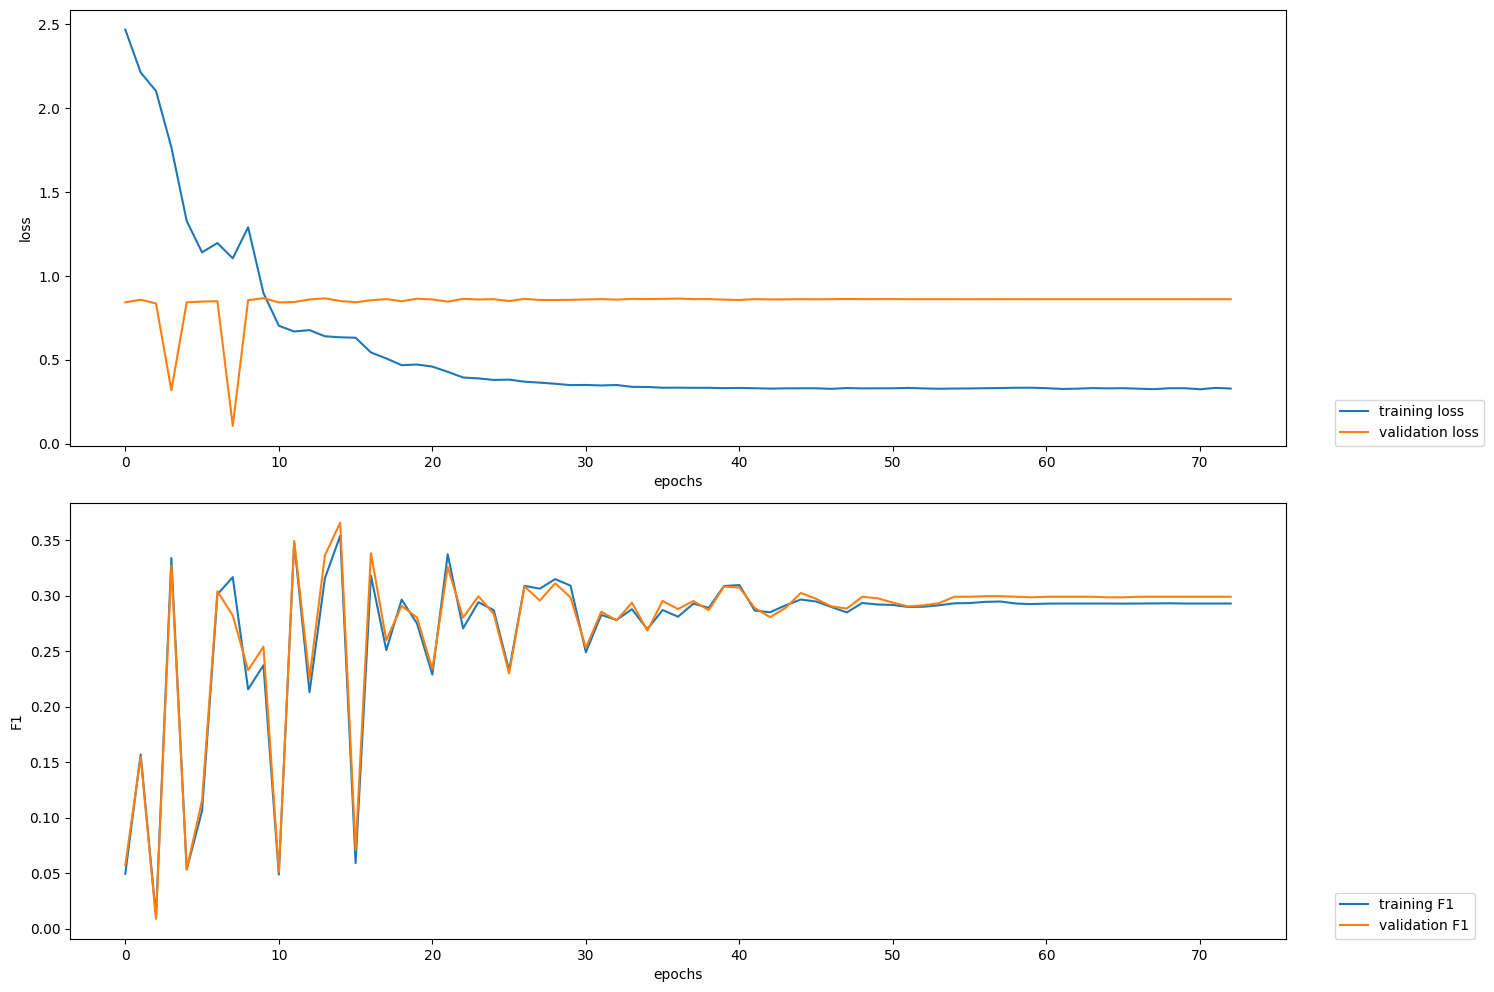

100%|██████████| 79/79 [00:34<00:00,  2.31it/s]

2023-04-21 02:39:14,510 Evaluating as a multi-label problem: True



100%|██████████| 10/10 [00:04<00:00,  2.38it/s]

2023-04-21 02:39:20,997 Evaluating as a multi-label problem: False



100%|██████████| 10/10 [00:04<00:00,  2.26it/s]

2023-04-21 02:39:25,523 Evaluating as a multi-label problem: True


,split,index,B-ADR,I-ADR,E-ADR,B-Drug,B-Finding,B-Disease,B-Symptom,E-Finding,...,E-Disease,E-Symptom,E-Drug,I-Symptom,I-Drug,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.623118,0.286095,0.530208,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.496408,0.095961,0.385948,0.048855
1,train,recall,0.465620,0.168802,0.480605,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.294492,0.074335,0.294492,0.048834
2,train,f1-score,0.532977,0.212327,0.504189,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.369675,0.083300,0.332255,0.048841
3,train,support,4712.000000,4449.000000,3506.000000,1396.0,309.0,231.0,222.0,200.0,...,119.0,114.0,111.0,104.0,50.0,50.0,15722.000000,15722.000000,15722.000000,15722.000000
4,dev,precision,0.657205,0.257971,0.553140,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.508628,0.097888,0.391855,NaN
5,dev,recall,0.462366,0.172147,0.510022,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.299613,0.076302,0.299613,NaN
6,dev,f1-score,0.542831,0.206497,0.530707,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.377094,0.085336,0.338059,NaN
7,dev,support,651.000000,517.000000,449.000000,184.0,64.0,31.0,25.0,34.0,...,15.0,13.0,20.0,23.0,7.0,13.0,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.654930,0.258621,0.558974,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.504296,0.098168,0.382143,0.049603
9,test,recall,0.484375,0.171429,0.493213,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.295123,0.076601,0.295123,0.049561


In [19]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [18]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.